# Lecture 23 - Markov Chain Monte Carlo III

PyMC is a python library for probabilistic (Bayesian) programming.

It is a fast and well-maintained library. In this handout, we will demonstrate why PyMC is so cool.

In [28]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from IPython.core.pylabtools import figsize
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

# Sampling from standard distributions using PyMC

## Recall Example 3: Sampling from an Exponential using Metropolis Hastings

Let's take $\mathcal{X}=(0,\infty)$ and:
$$
\pi(x) = \frac{e^{-10x}}{10}
$$

We want to sample from the above distribution.


### First step : Define the model/likelihood/distribution

In [29]:
def make_model():
    x = pm.Exponential('x', 10) # pre-defined Pymc Exponential distribution
    return locals()

### Second step: Define the sampling method to use

In [30]:
M = pm.MCMC(make_model())

# Parameters of the proposal:
sigma = 1.
# Number of steps
n = 10000

M.use_step_method(pm.Metropolis, M.x, proposal_sd= sigma) # Metropolis Hastings 

### Question

1. What happens when you change the sigma parameter (too large or too small)?

### Third step: Sample from the distribution

In [31]:
M.sample(n, burn = 2000, thin = 2)
samples = M.trace('x')[:]

 [-----------------100%-----------------] 10000 of 10000 complete in 0.4 sec

Text(0,0.5,'$X_n$')

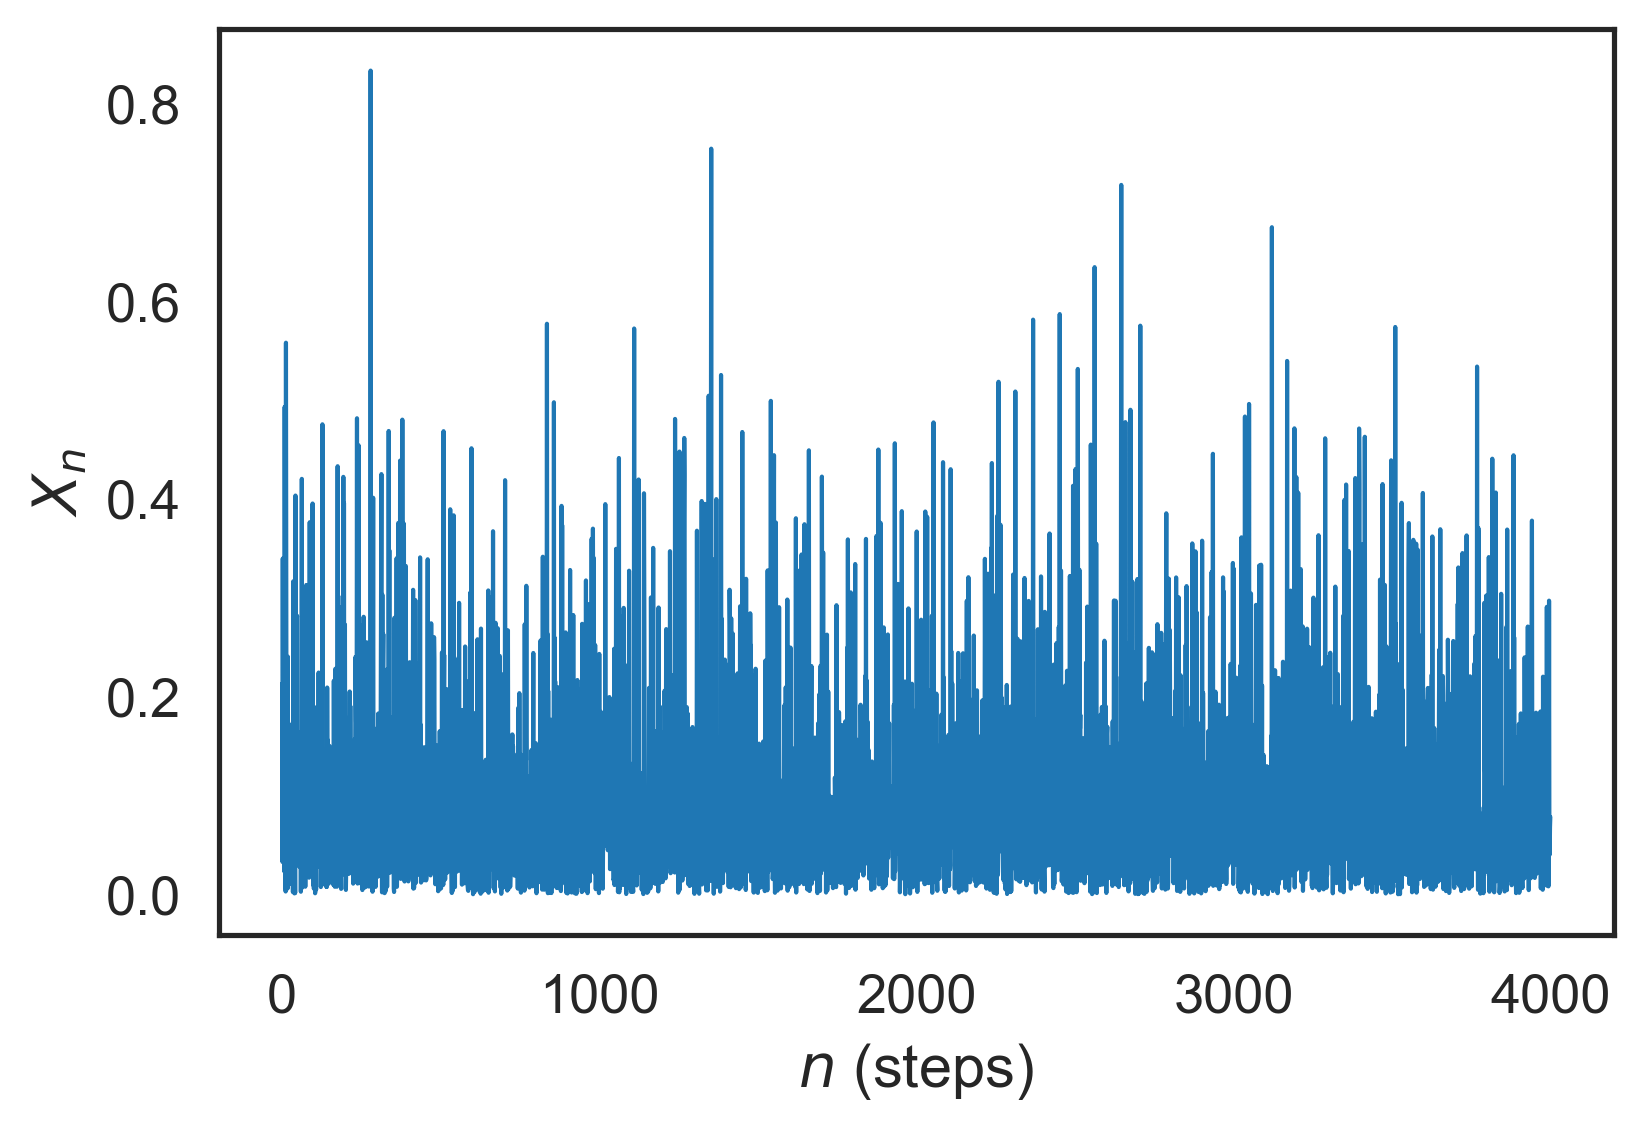

In [32]:
fig, ax = plt.subplots()
ax.plot(range(samples.shape[0]), samples, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')

### Questions 

1. Why does the burn parameter do?
2. What does the thin parameter do?

Let's estimate the mean and the variance by sampling average and compare them to the true values.
**Note:** It is also possible to get error bars because the CLT holds (if certain regularity condtions hold), but we do not do it here.

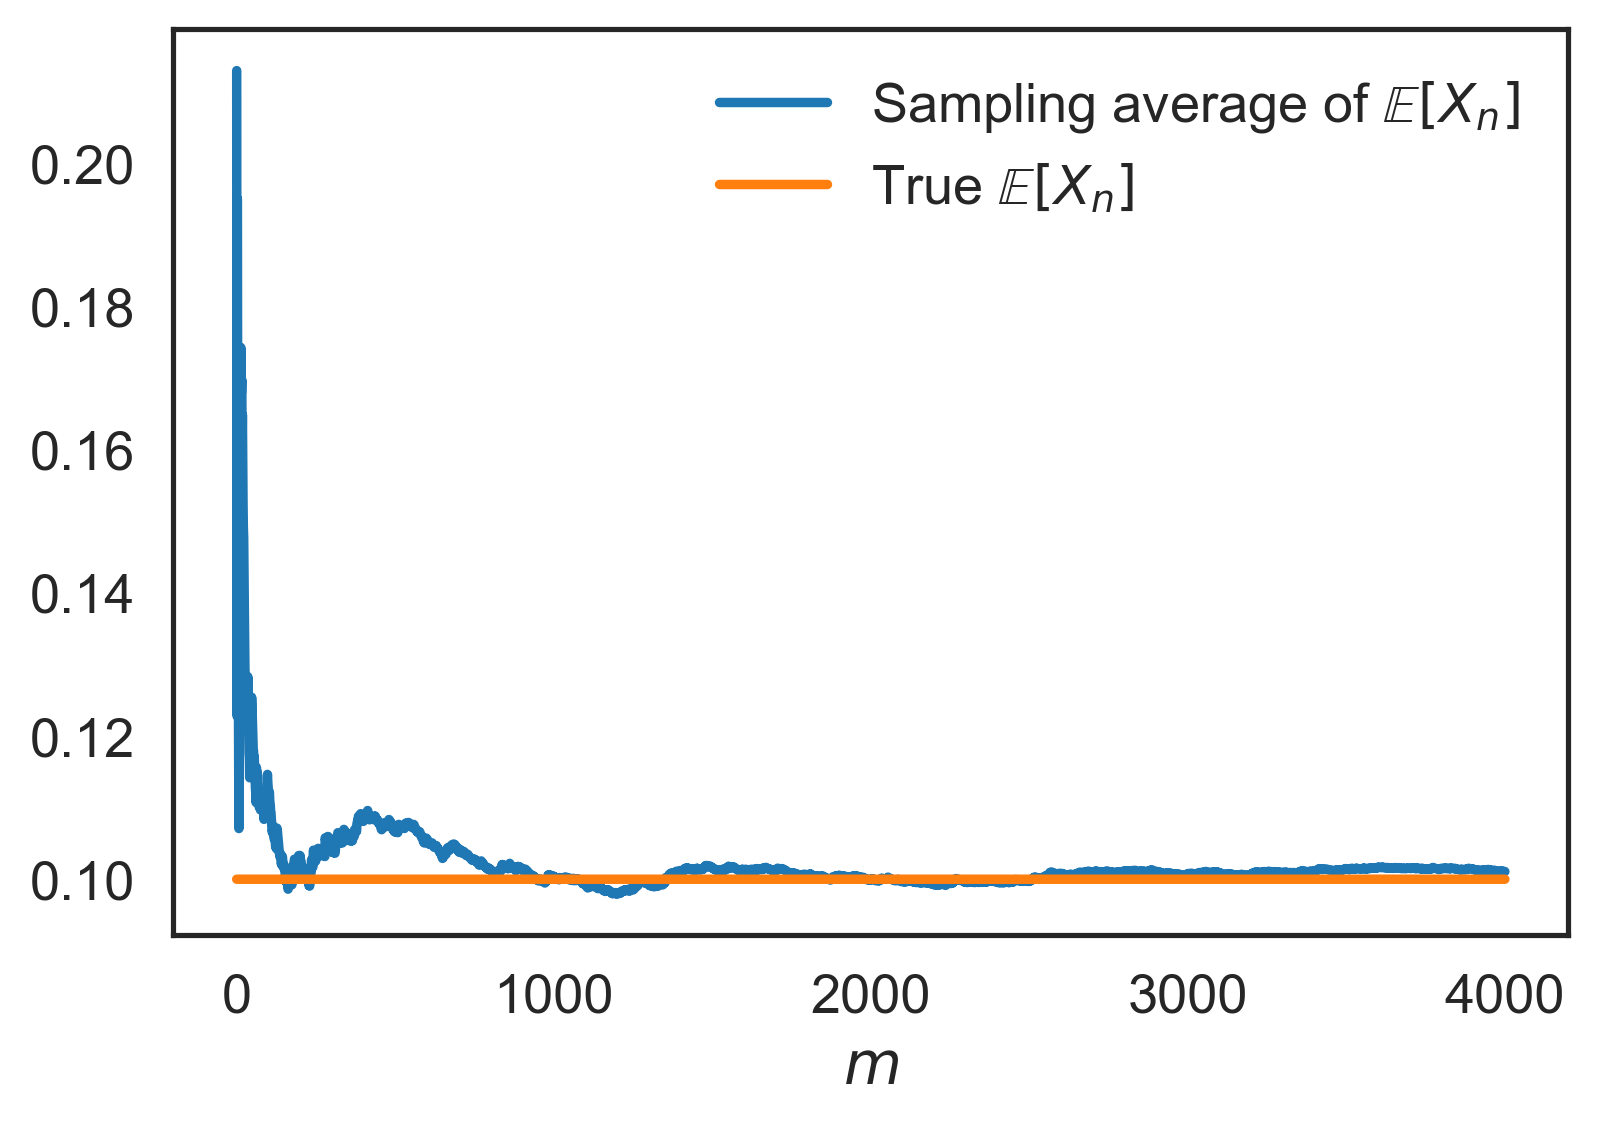

In [33]:
fig, ax = plt.subplots()
idx = np.arange(1, samples.shape[0] + 1)
X_ave = np.cumsum(samples) / idx
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_n]$')
ax.plot(idx, 0.10 * np.ones(idx.shape[0]), label='True $\mathbb{E}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$');

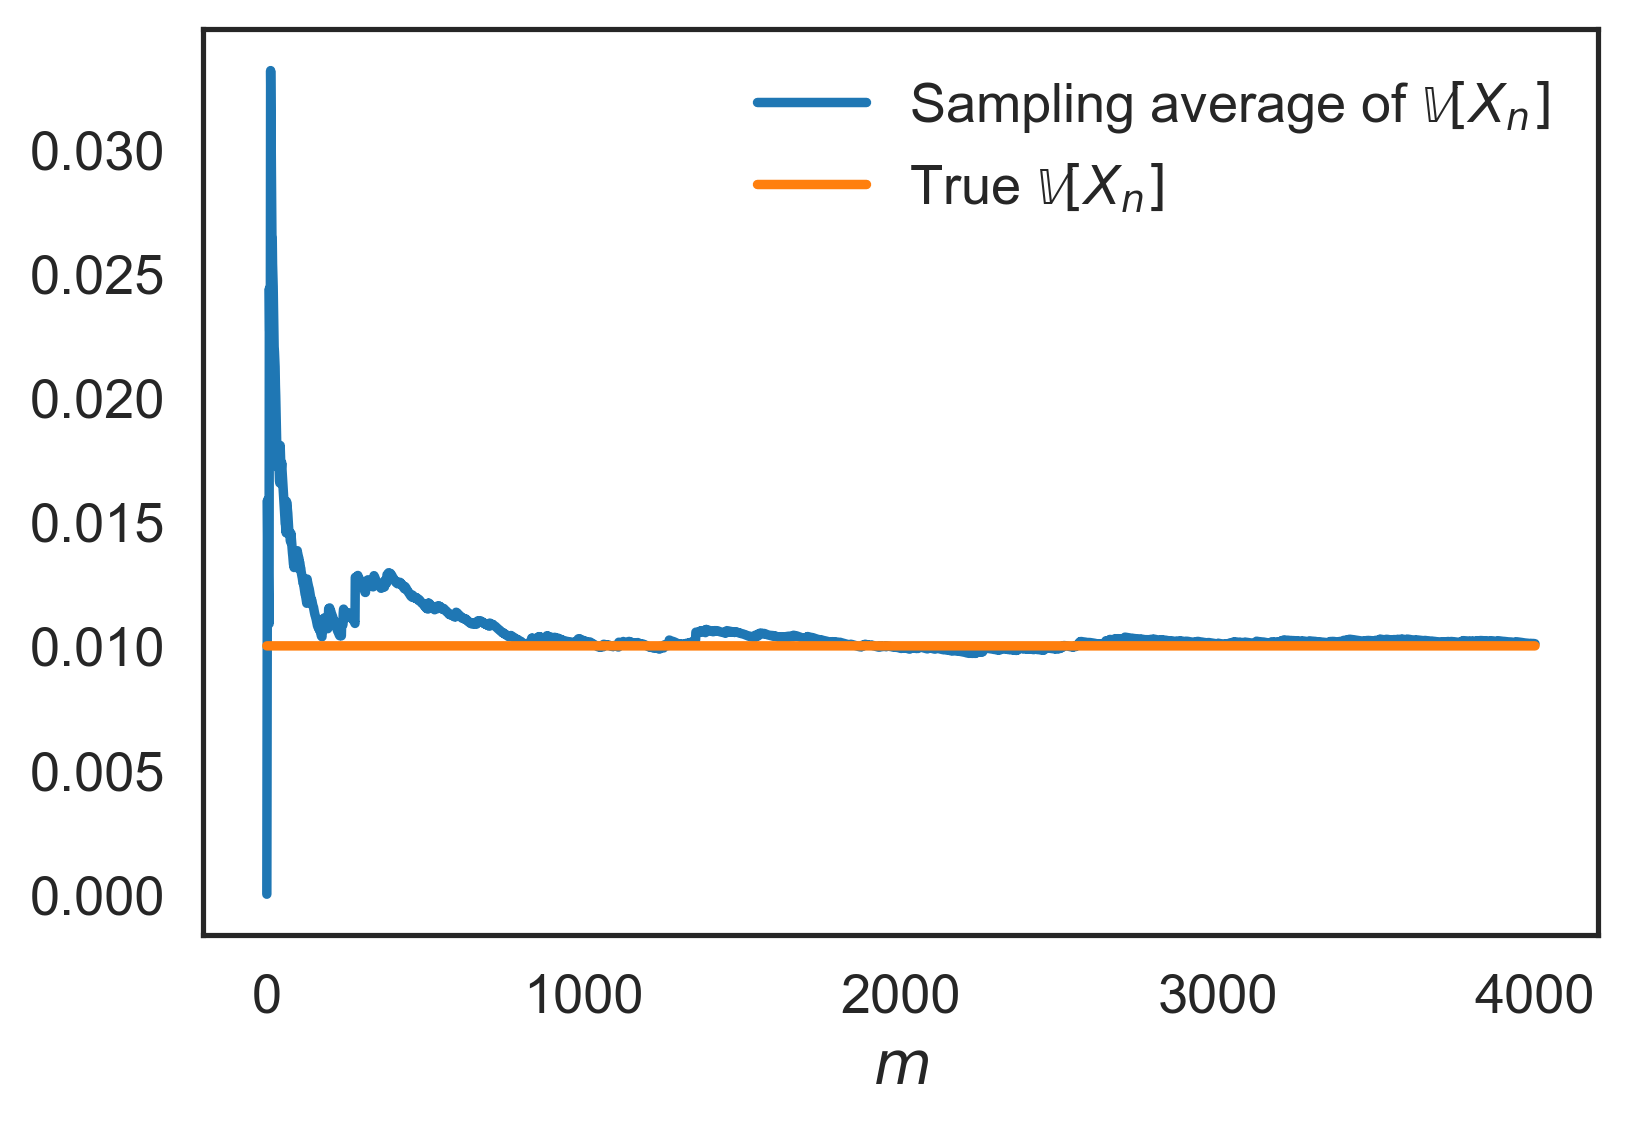

In [34]:
fig, ax = plt.subplots()
X2_ave = np.cumsum(samples ** 2) / idx
X_var = X2_ave - X_ave ** 2
ax.plot(idx, X_var, label='Sampling average of $\mathbb{V}[X_n]$')
ax.plot(idx, 0.01 * np.ones(idx.shape[0]), label='True $\mathbb{V}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$');

Now, let's use these *independent* variables to draw the empirical histrogram and compare it to the true density:

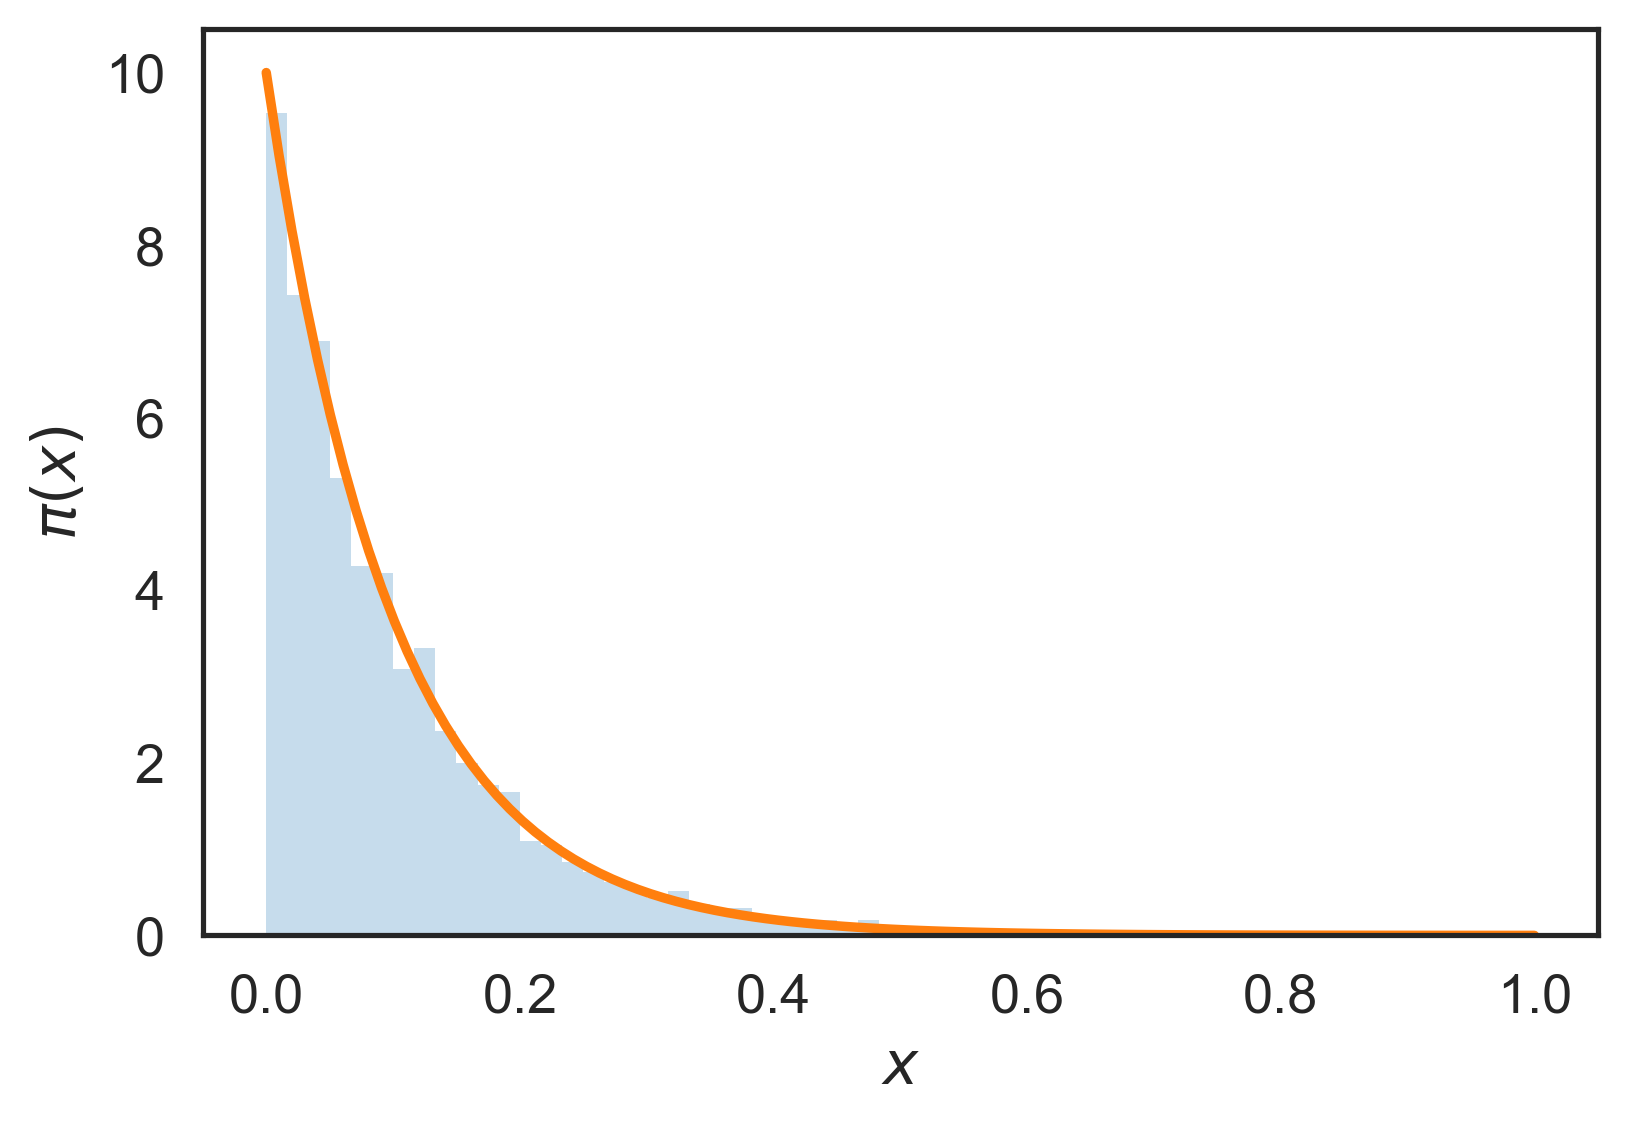

In [35]:
fig, ax = plt.subplots()
ax.hist(samples, normed=True, alpha=0.25, bins=50);
xx = np.linspace(0, 1, 100)
ax.plot(xx, 10. * np.exp(-10. * xx))
ax.set_xlabel('$x$')
ax.set_ylabel('$\pi(x)$');

# PyMC Tutorial 1 - Real Data Example : Coal Mining Disaster

For this tutorial, we are going to work on Coal Mining disaster dataset. Consider the following time series dataset of recorded coal mining disasters in the UK from 1851 to 1962 [1, 2]. Let us first import this dataset and visualize it.

In [36]:
disaster_data = pd.read_csv('coal_mining_disasters.csv')
disaster_data

,year,disasters
0,1851,4
1,1852,5
2,1853,4
3,1854,0
4,1855,1
5,1856,4
6,1857,3
7,1858,4
8,1859,0
9,1860,6


Text(0.5,1,'Recorded coal mining disasters in the UK.')

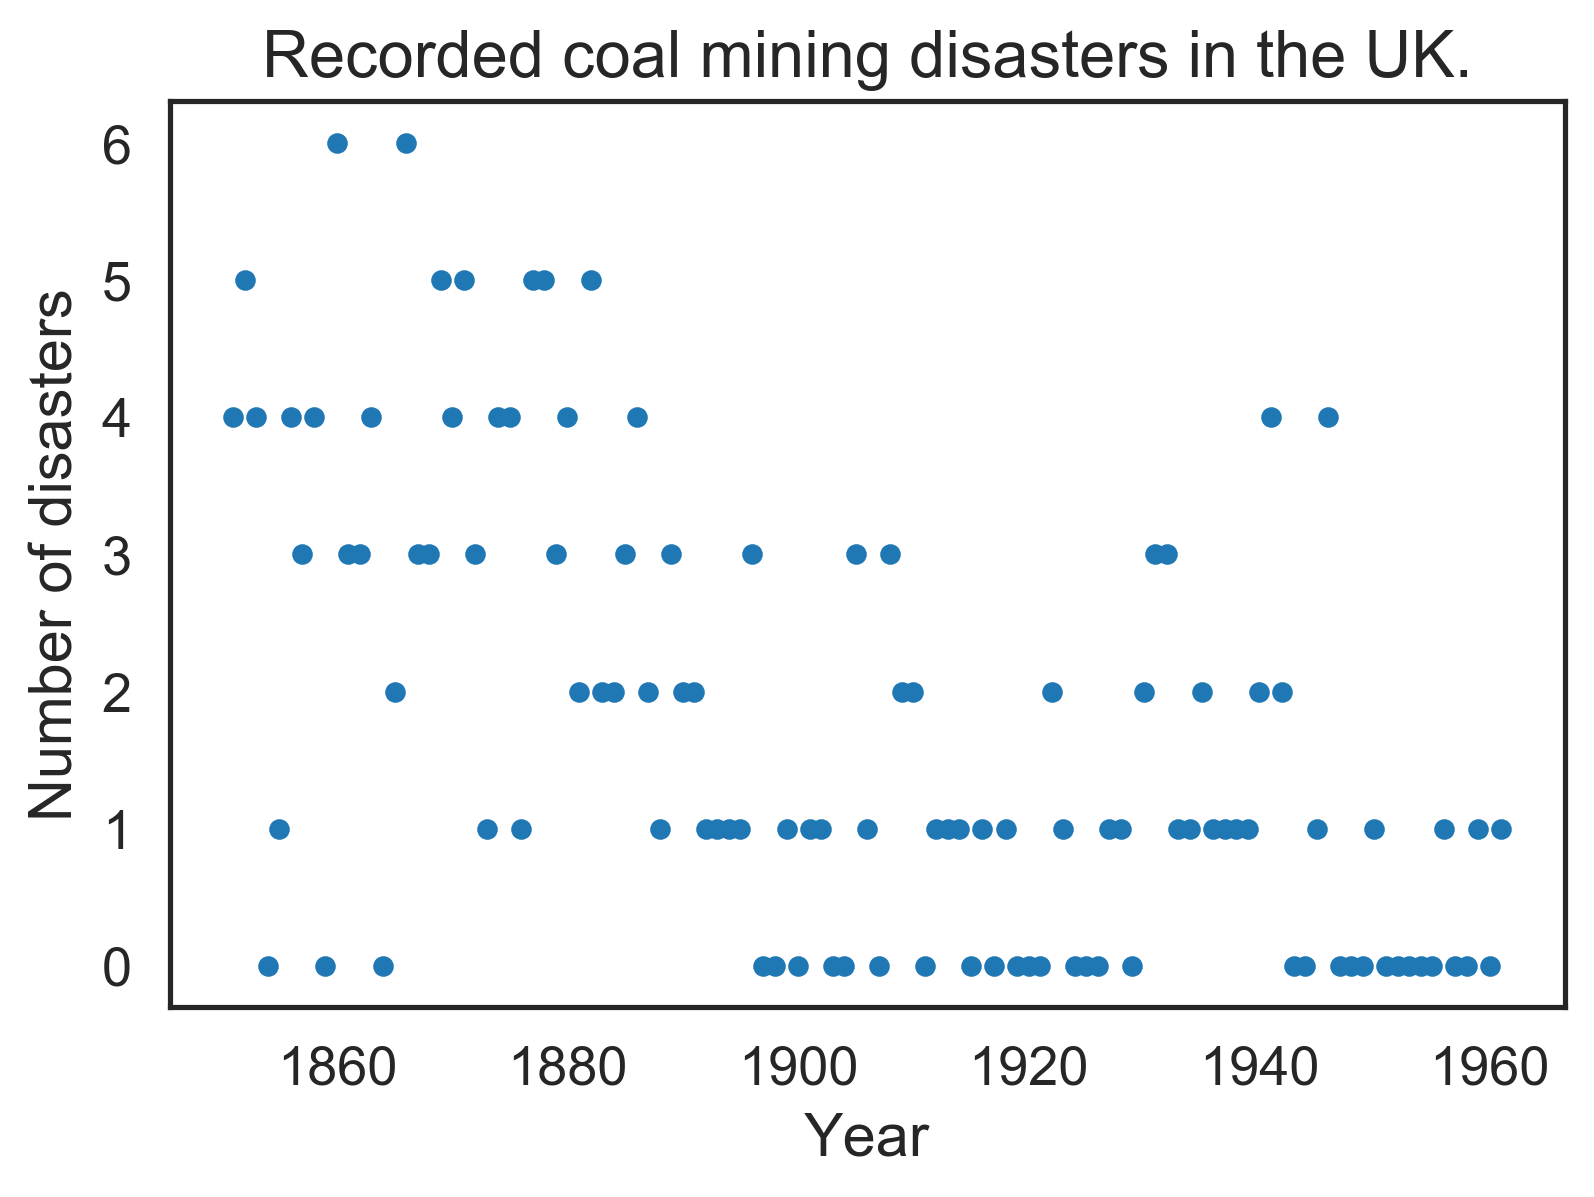

In [37]:
plt.scatter(disaster_data.year, disaster_data.disasters, marker= '.')
plt.xlabel('Year')
plt.ylabel('Number of disasters')
plt.title('Recorded coal mining disasters in the UK.')

Text(0.5,1,'Recorded coal mining disasters in the UK.')

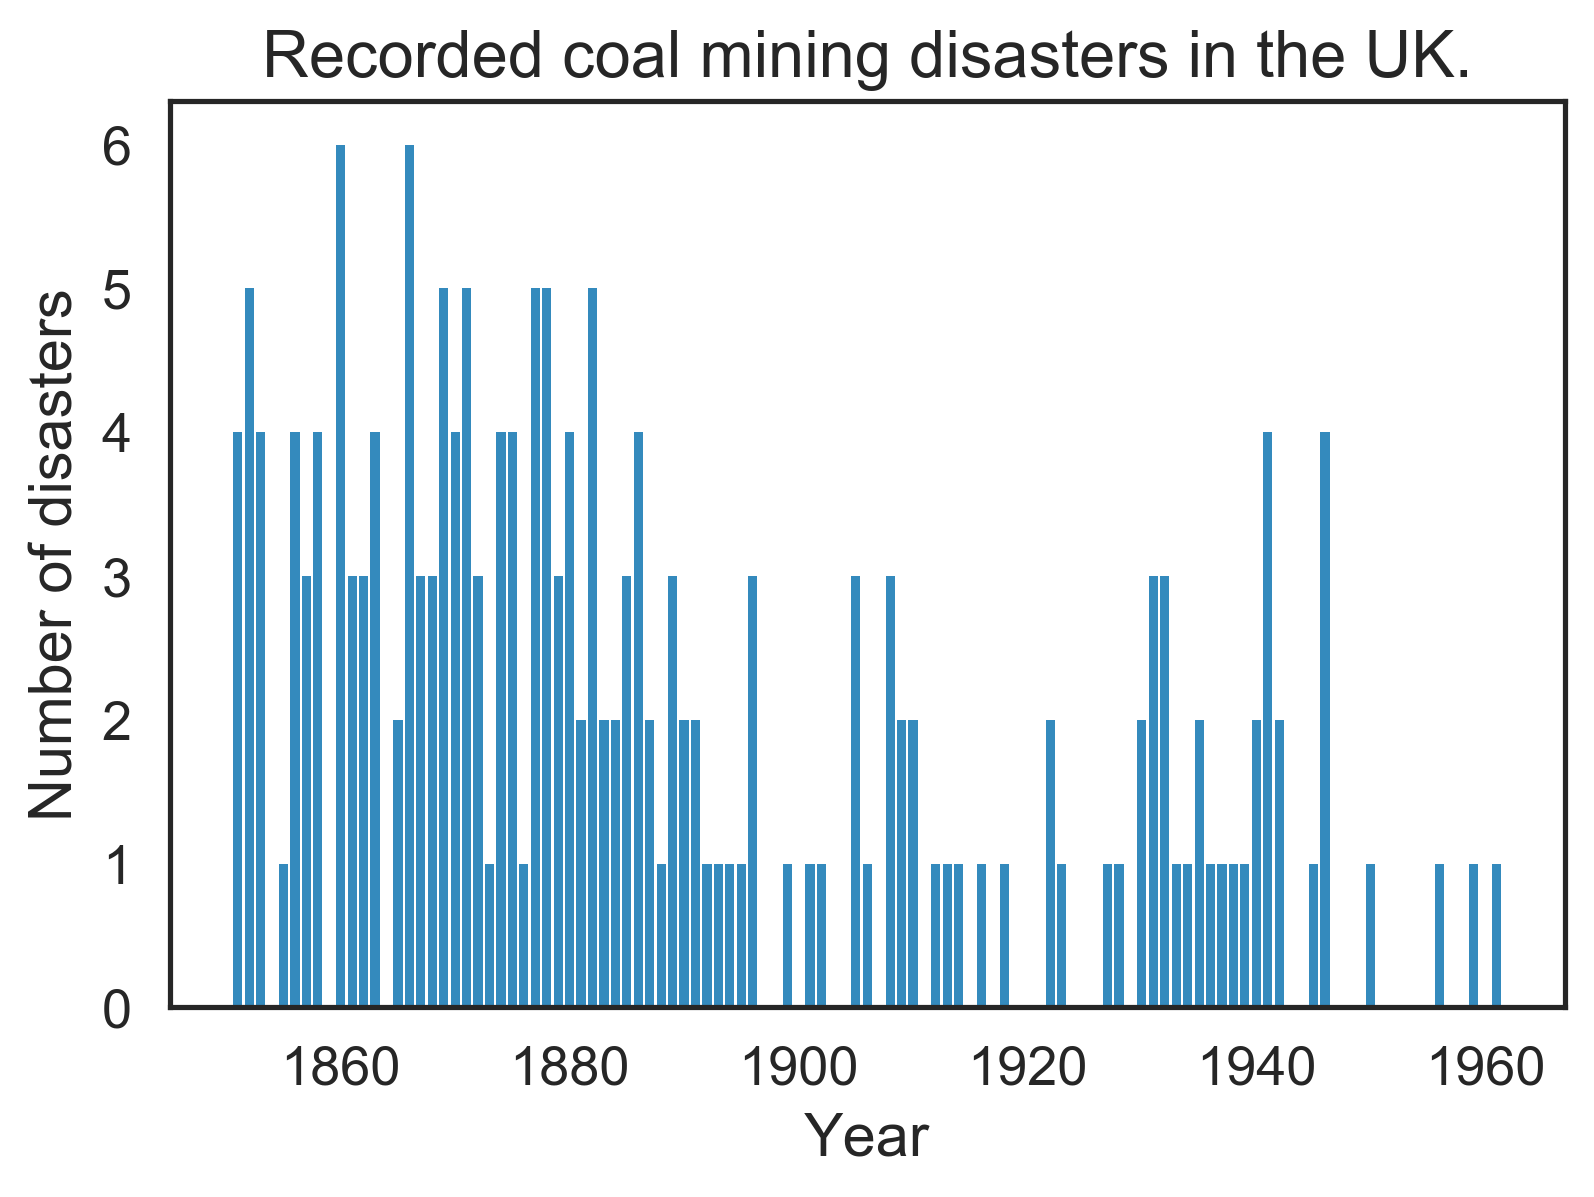

In [38]:
plt.bar(disaster_data.year, disaster_data.disasters, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Number of disasters")
plt.title("Recorded coal mining disasters in the UK.")

## Questions

1. How can we represent this disaster time series data? What are quantities of interests?
2. Is 'disasters' variable categorial or continous? Can it be negative? What are some other constraints?

# Information about the dataset 

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series (more disasters in early years), and from one with a smaller rate in the later part (less number of disasters in later years). We are interested in locating the change point in the series, which might be because of changes in mining safety regulations in latter years.

# Modeling Approach

How are we going to develop model for this data? A good starting point would be to think about *how this data might be generated?* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated [3].

1. We start by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of coal mining related disasters as sampled from a Poisson distribution.

2. Next, we think, "Ok, assuming number of disasters are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a rate parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier years and one for the later years. We don't know when the change in this rate parameter occurs though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 1 and 3", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$s are between 1-3, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. 

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.


Below we give a graphical visualization of this, where arrows denote `parent-child` relationships. (provided in the [Bayesian Methods for Hackers book](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) [3]).

<img src="http://i.imgur.com/7J30oCG.png" width = 700/>

More formally, we can express our model as:
$$ C_i \sim \text{Poisson}(\lambda)  $$
$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 



# Modeling with PyMC

The PyMC model code for solving this problem is taken from [Bayesian Methods for Hackers book](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) [3]).

## 1. Set up the model function

In [39]:
def make_model(disaster_data):
    """
    PyMC model (wrapping all the data and variables into a single function)
    Inputs:
    disaster_data (111 x 2): Pandas dataframe ( Years vs. Number of coal mining related disasters)
    Outputs:
    lamda_1, lamda_2, tau : stochastic parameters associated with the given model
    """
    
    # Load data
    num_disasters = disaster_data.disasters
    year = disaster_data.year
    n_count_data = disaster_data.shape[0]
    
    # Define Prior
    alpha = 1.0 / np.mean(num_disasters)
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
    @pm.deterministic
    def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
        out = np.zeros(n_count_data)
        out[:tau] = lambda_1  # lambda before tau is lambda1
        out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
        return out
    
    # Define Likelihood model
    observation = pm.Poisson("obs", lambda_, value=num_disasters, observed=True)

    return locals()
    

## 2. Sample from the posterior distribution

In [40]:
mcmc = pm.MCMC(make_model(disaster_data))
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.9 sec

Plotting lambda_1
Plotting lambda_2
Plotting tau


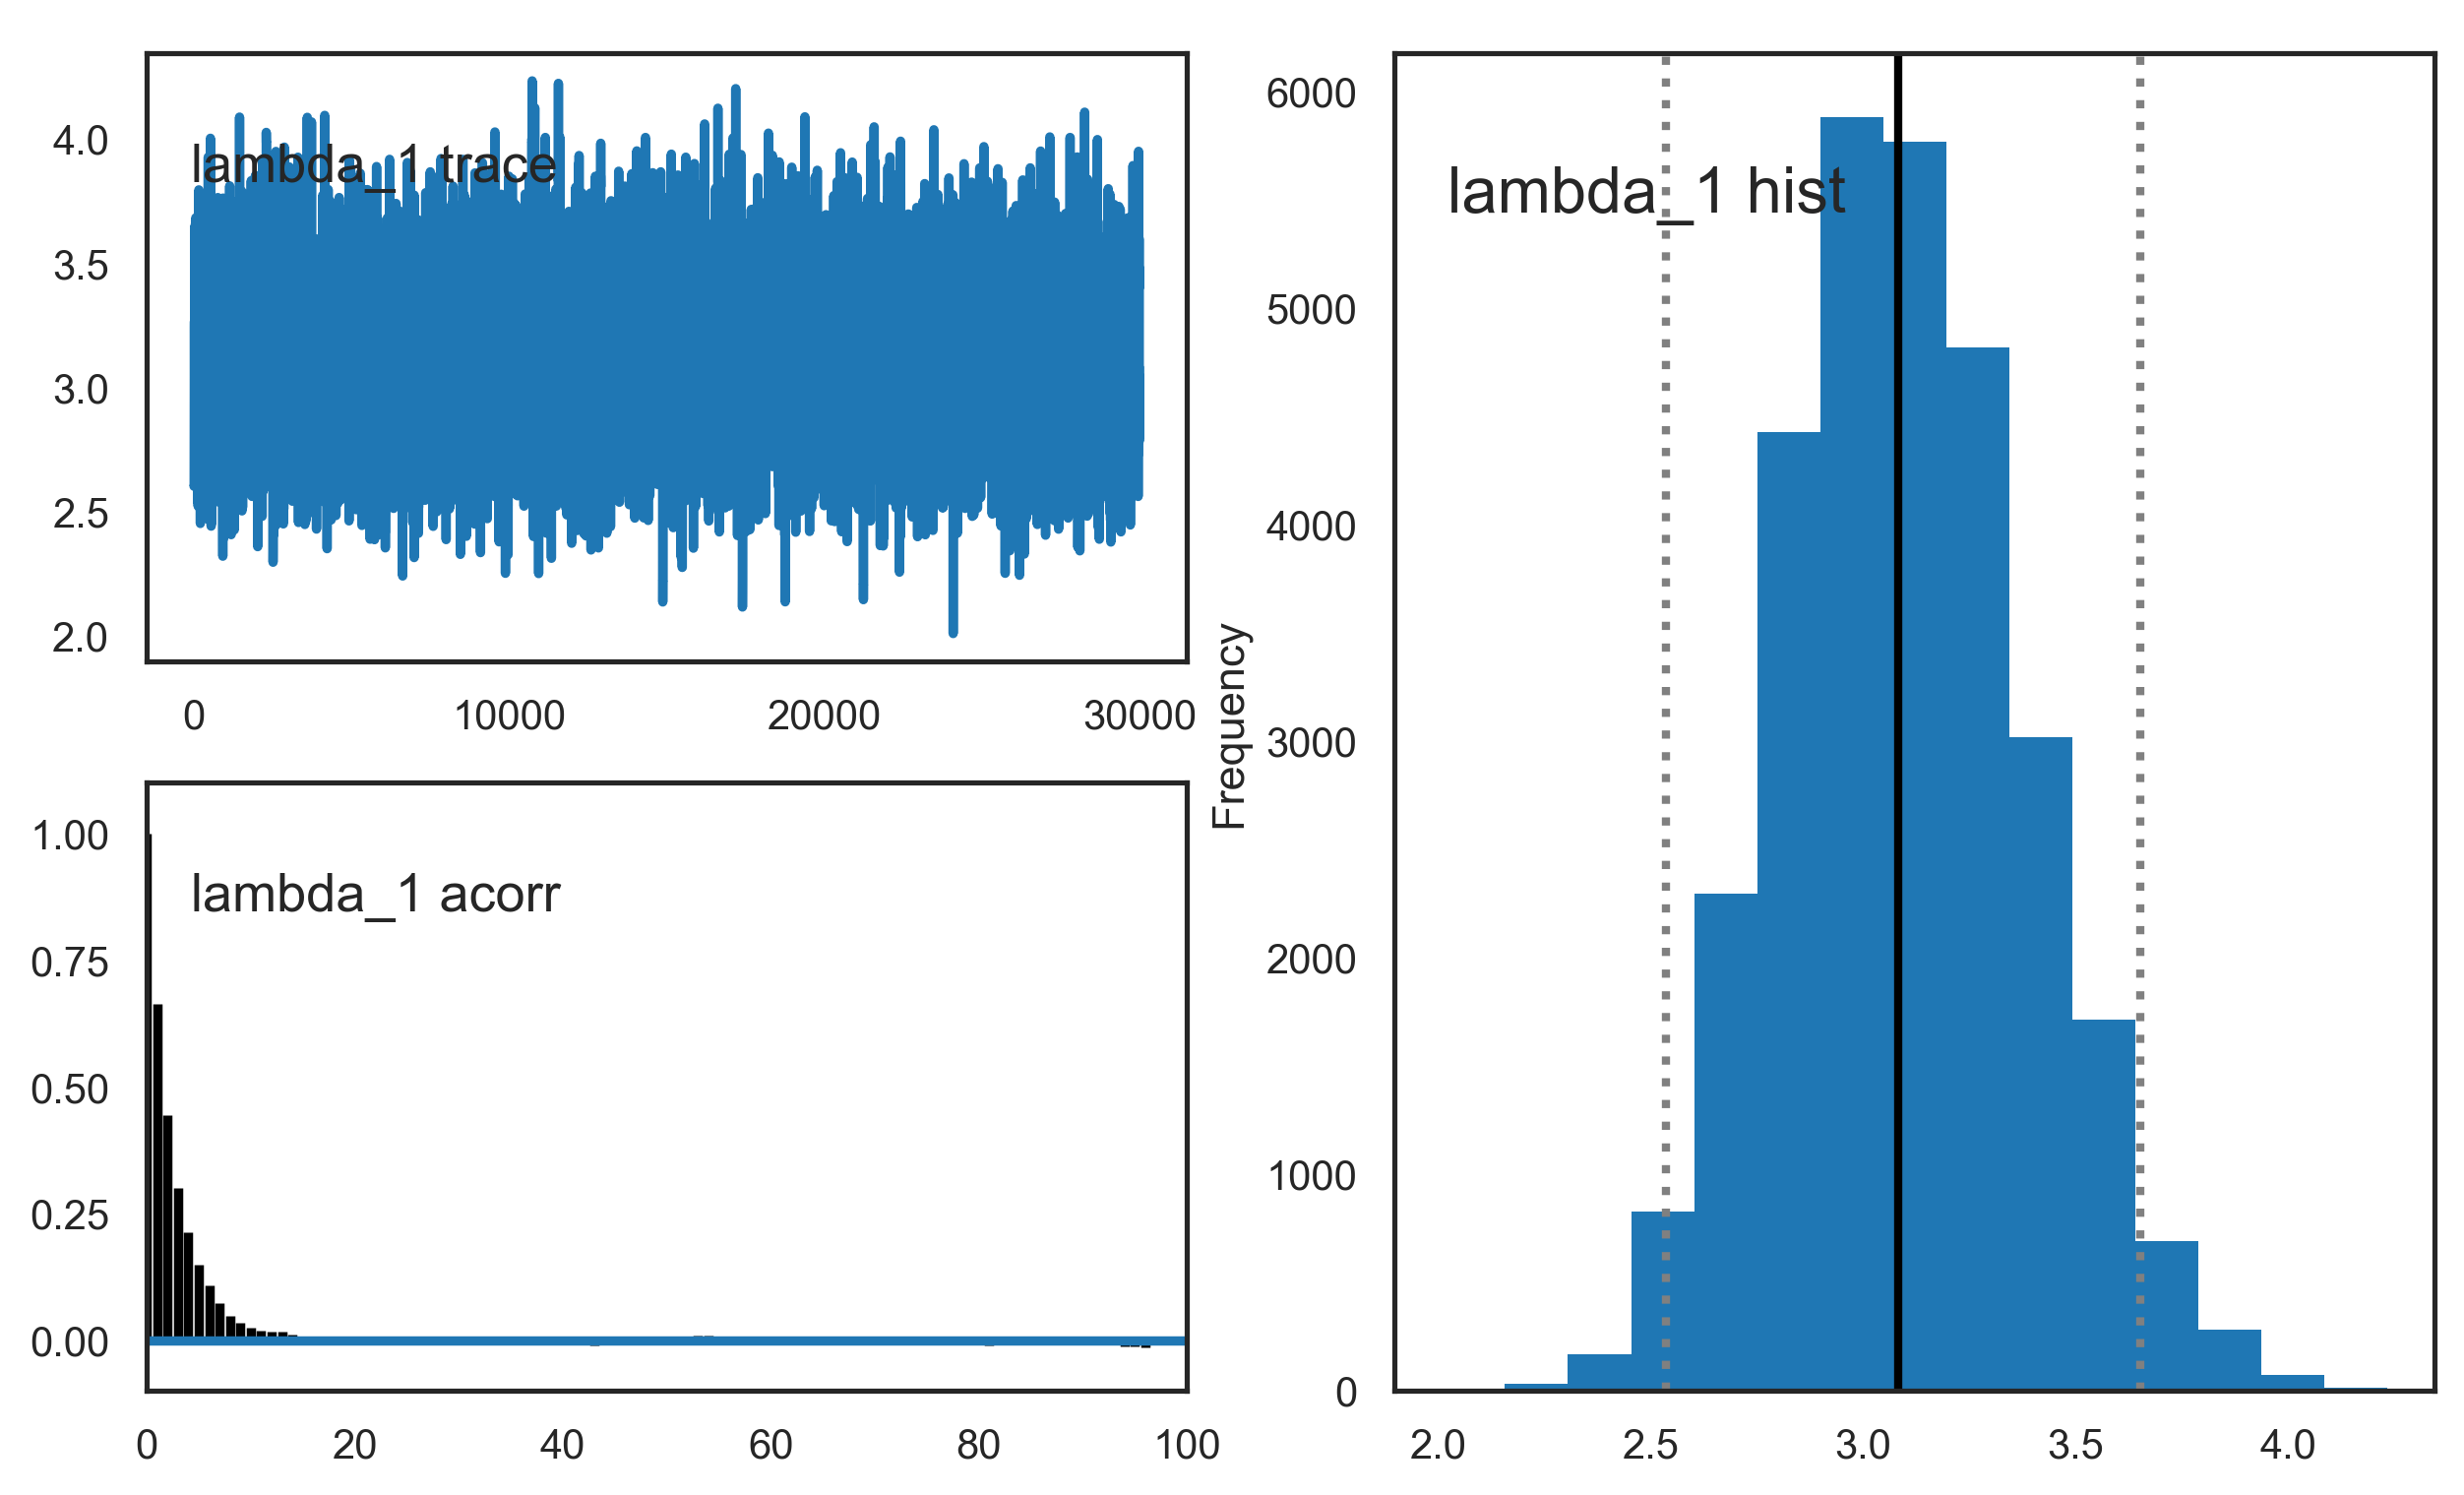

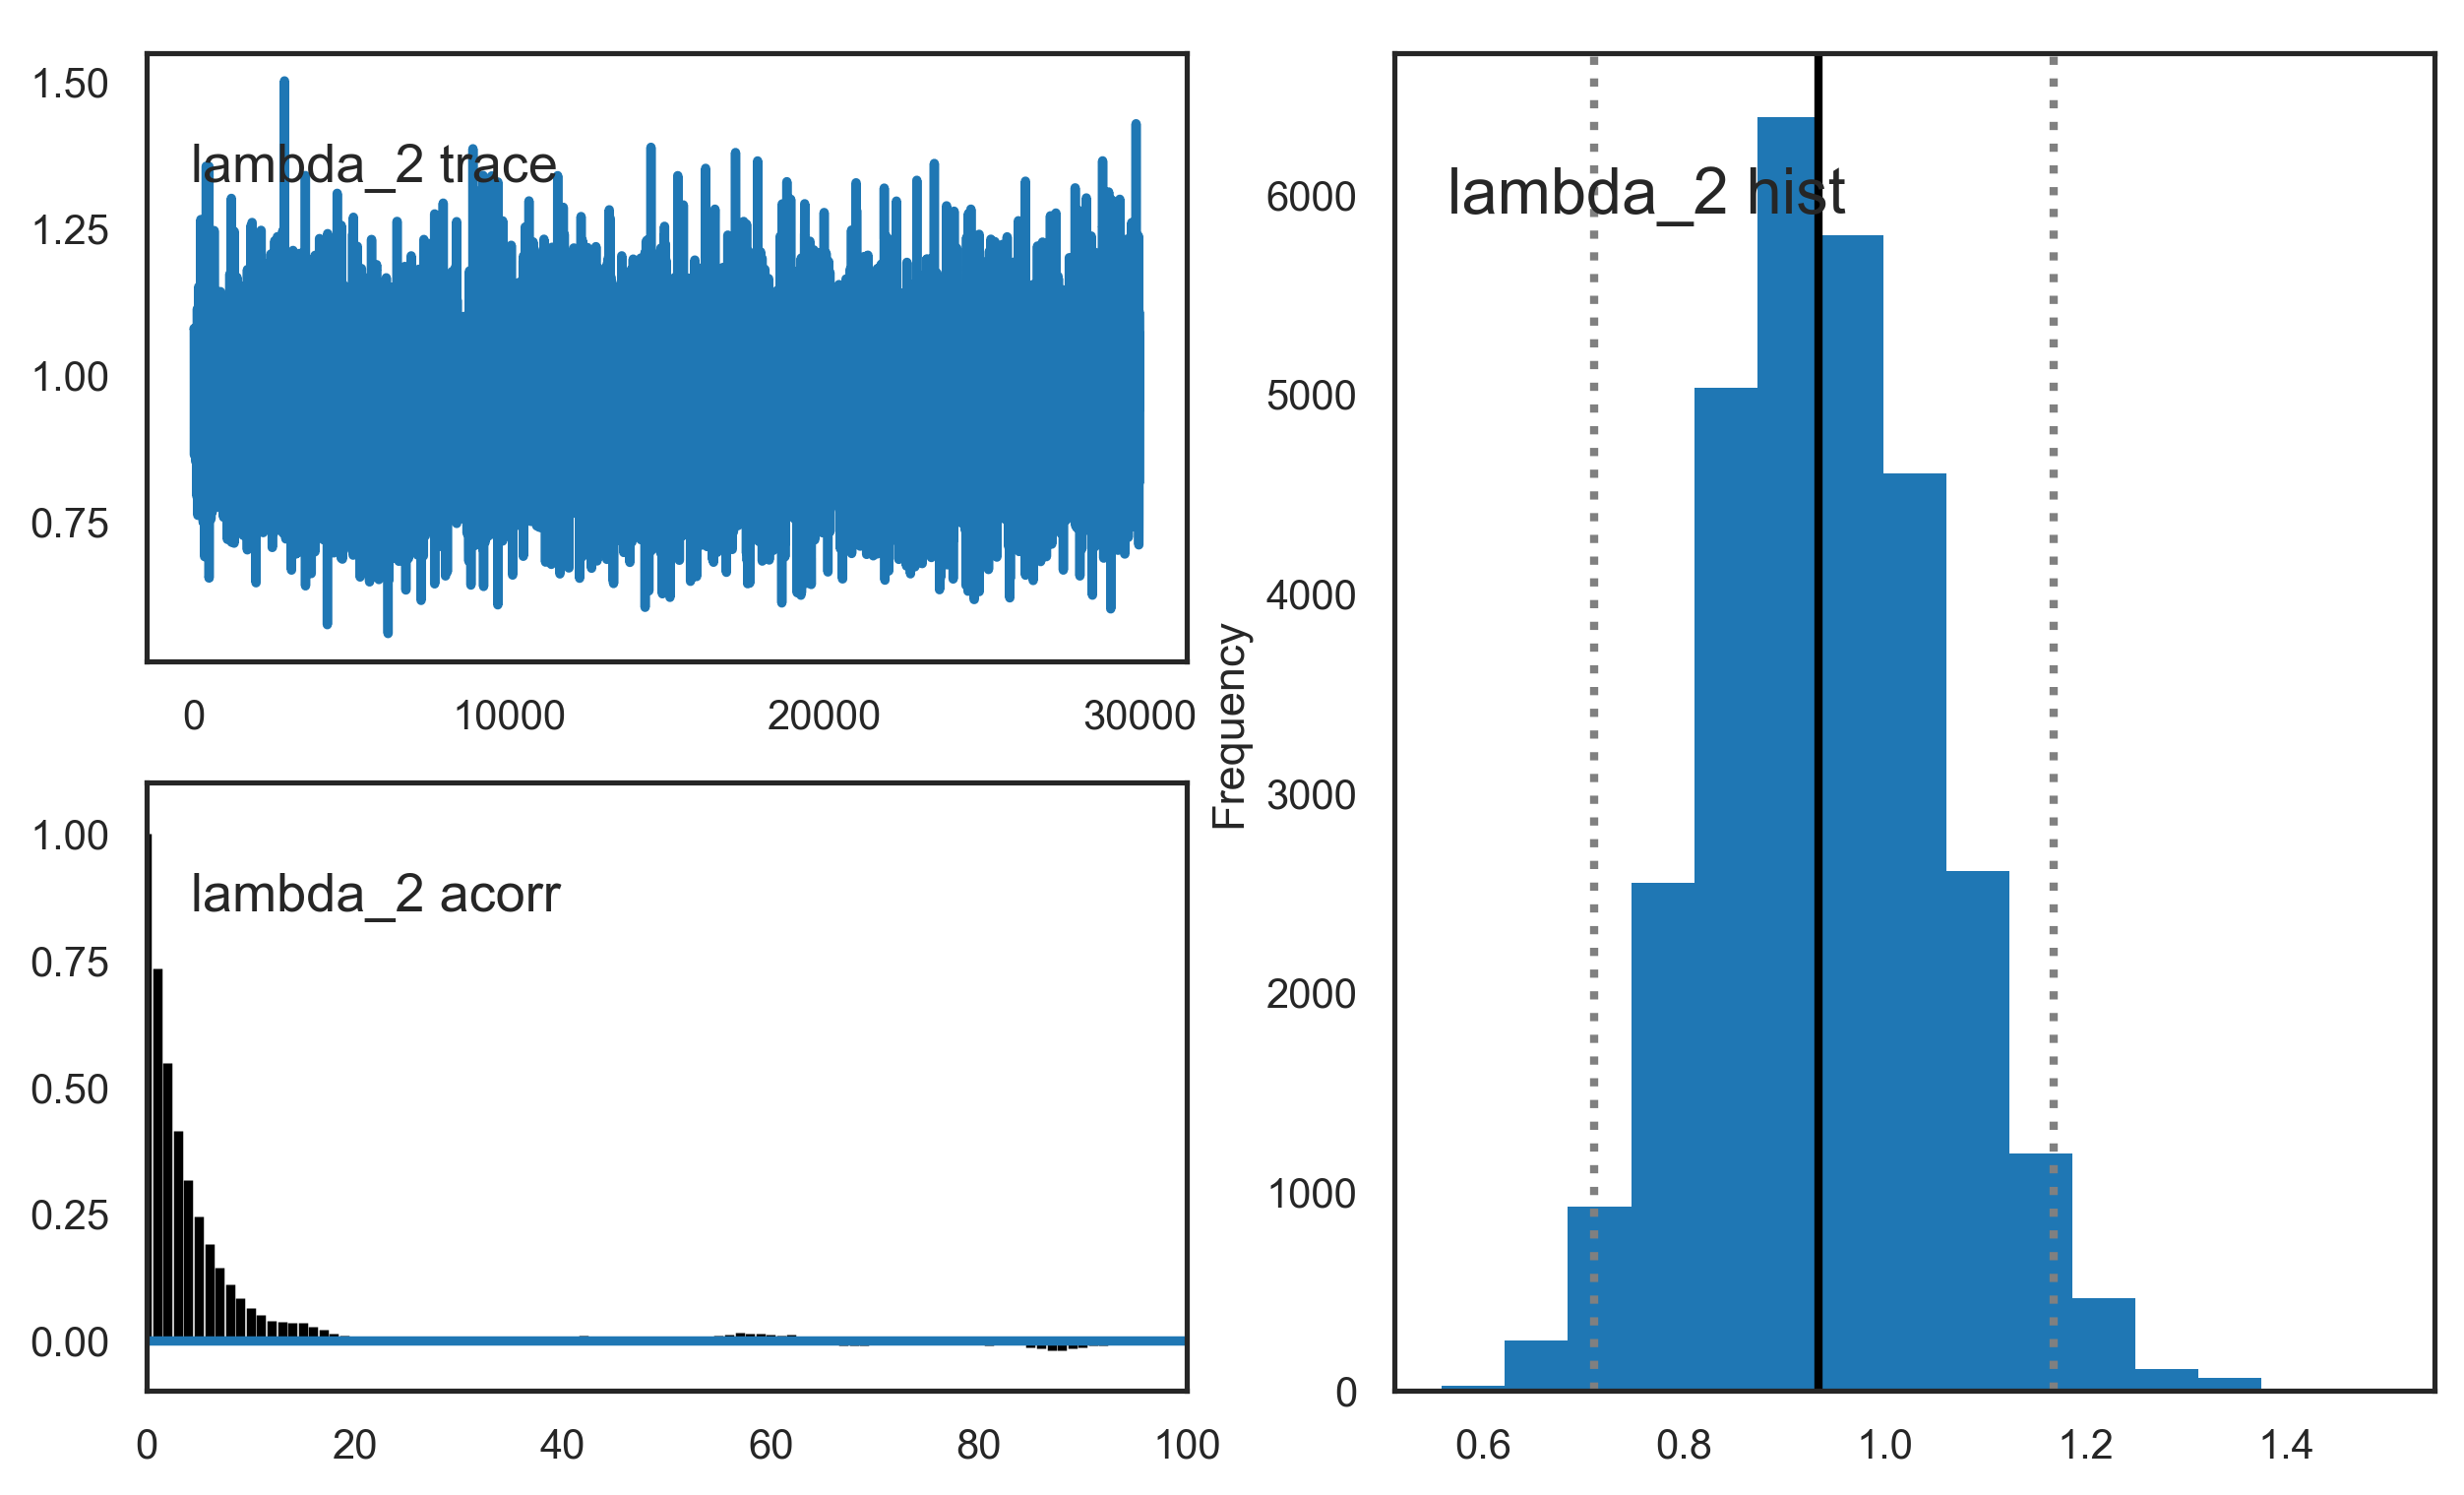

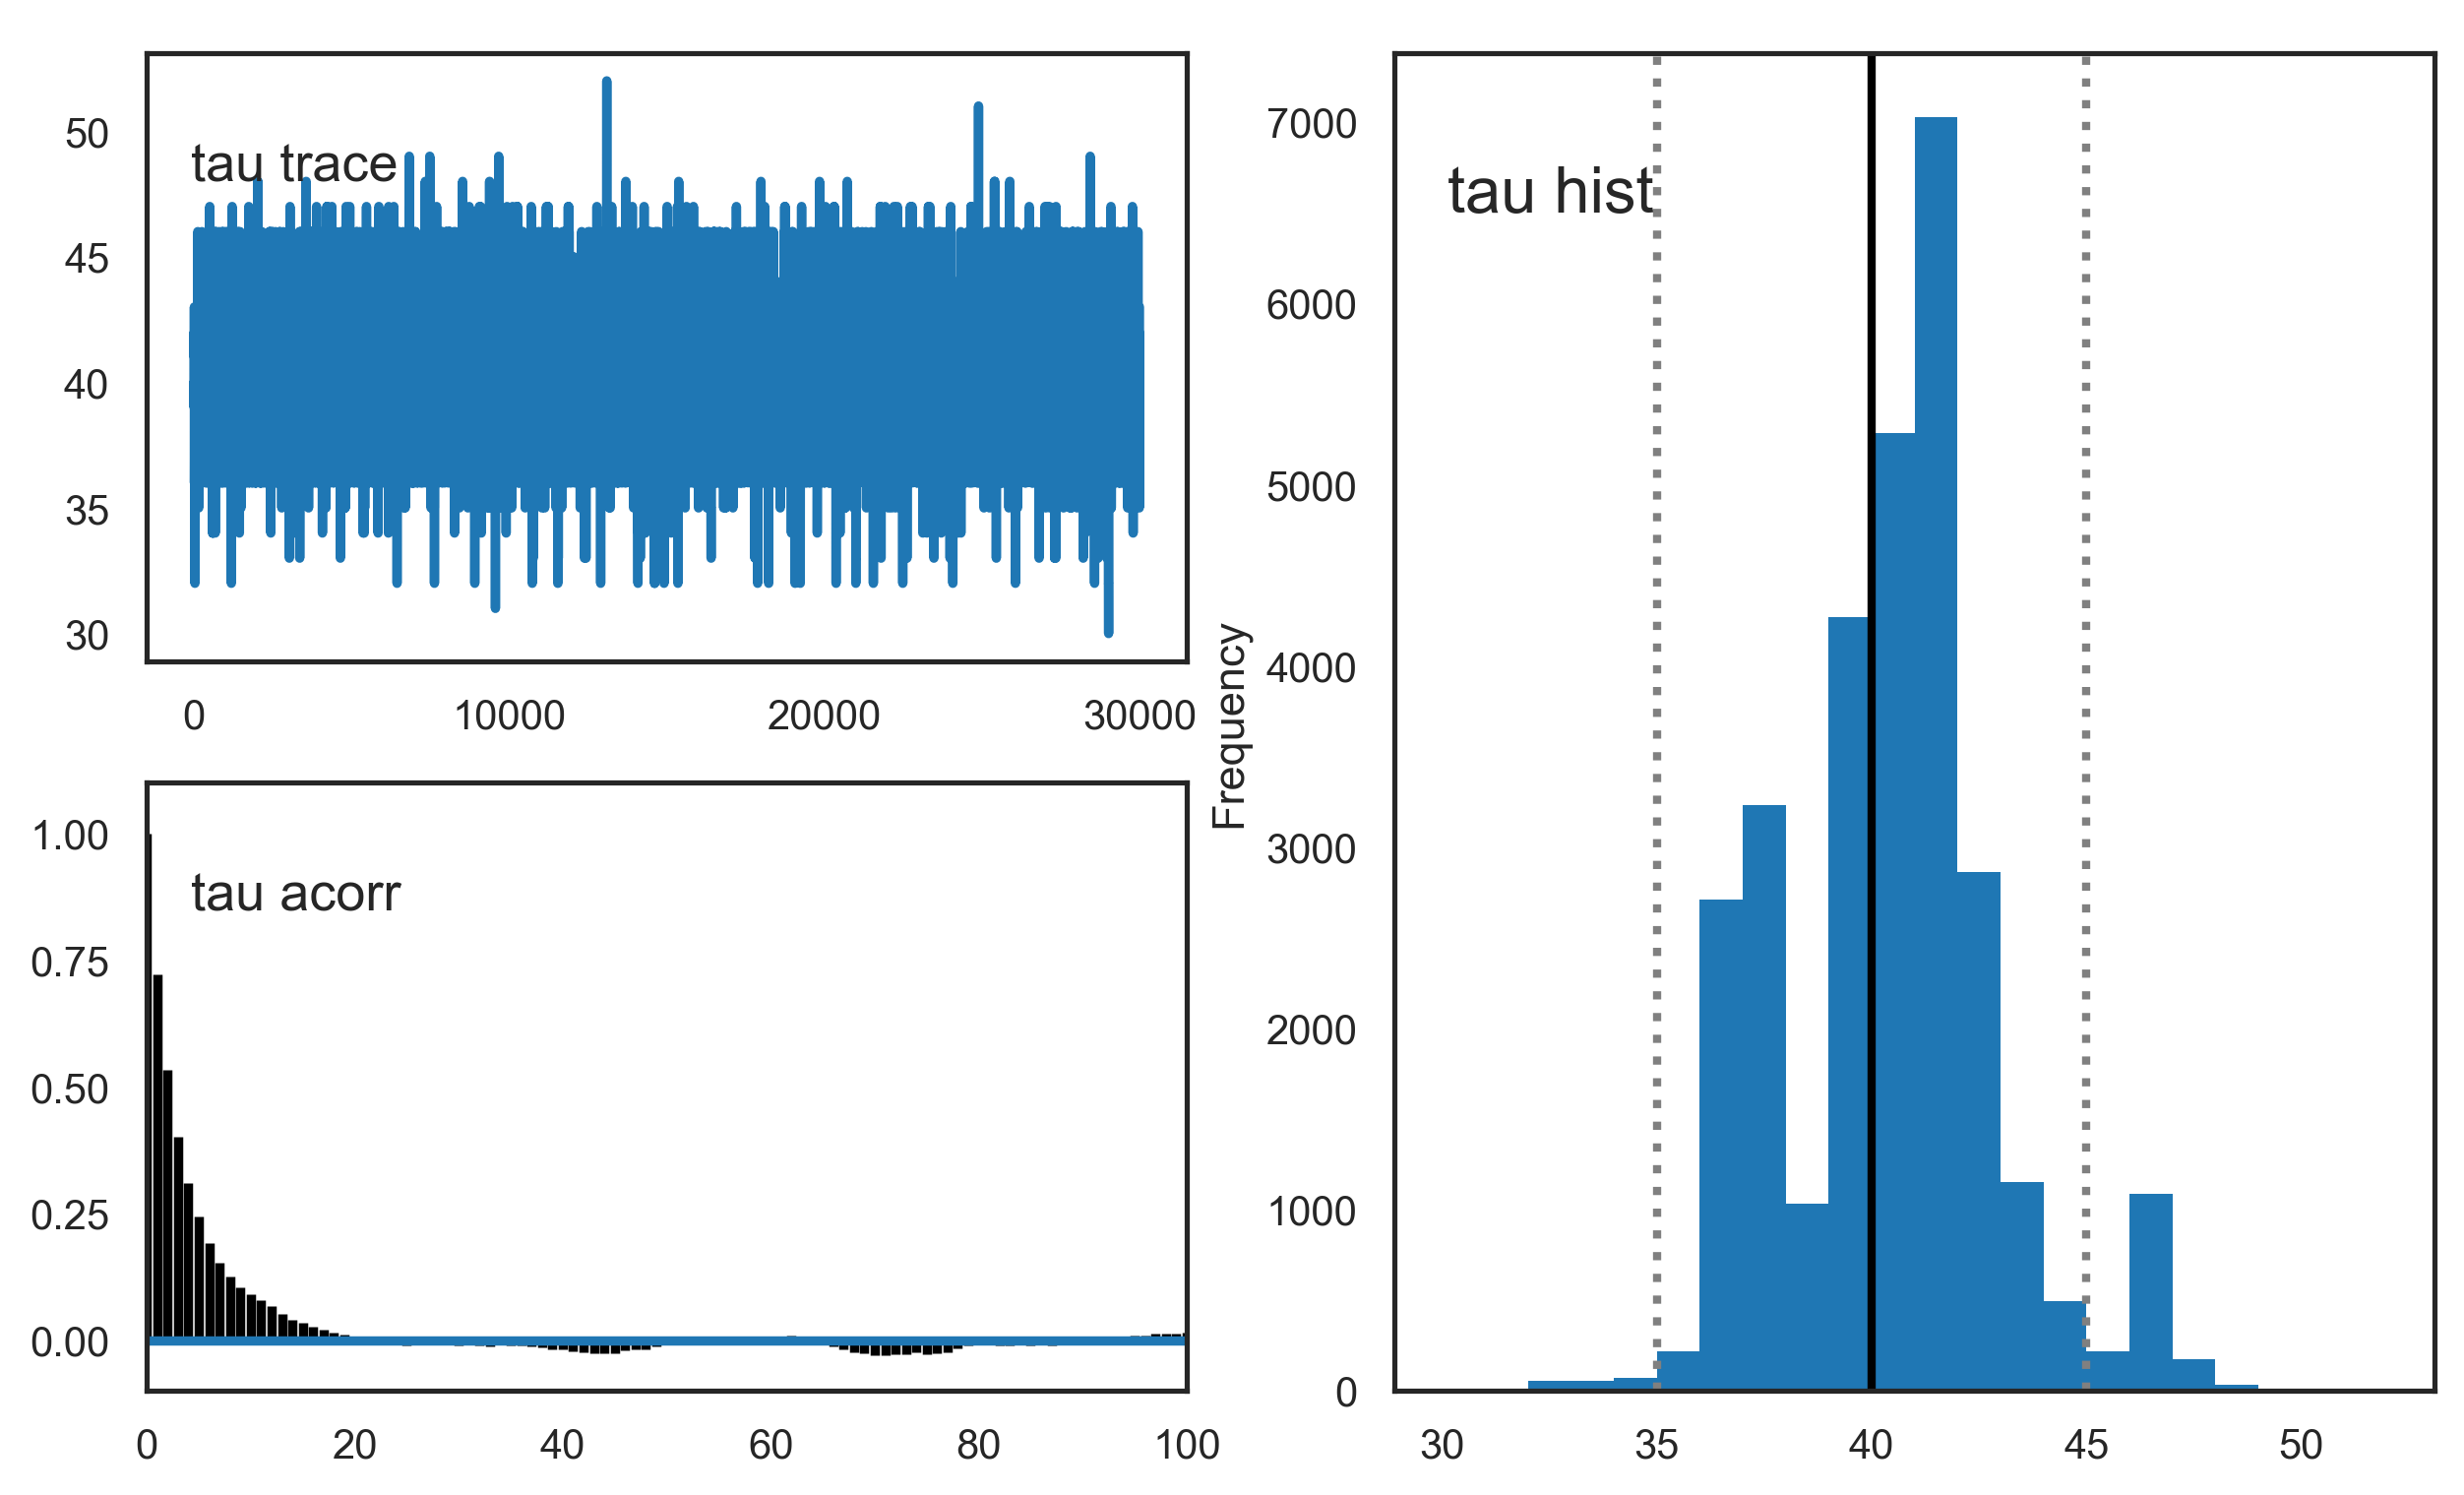

In [41]:
from pymc.Matplot import plot
plot(mcmc)

In [42]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

In [43]:
## 4. Plotting Posterior Distributions

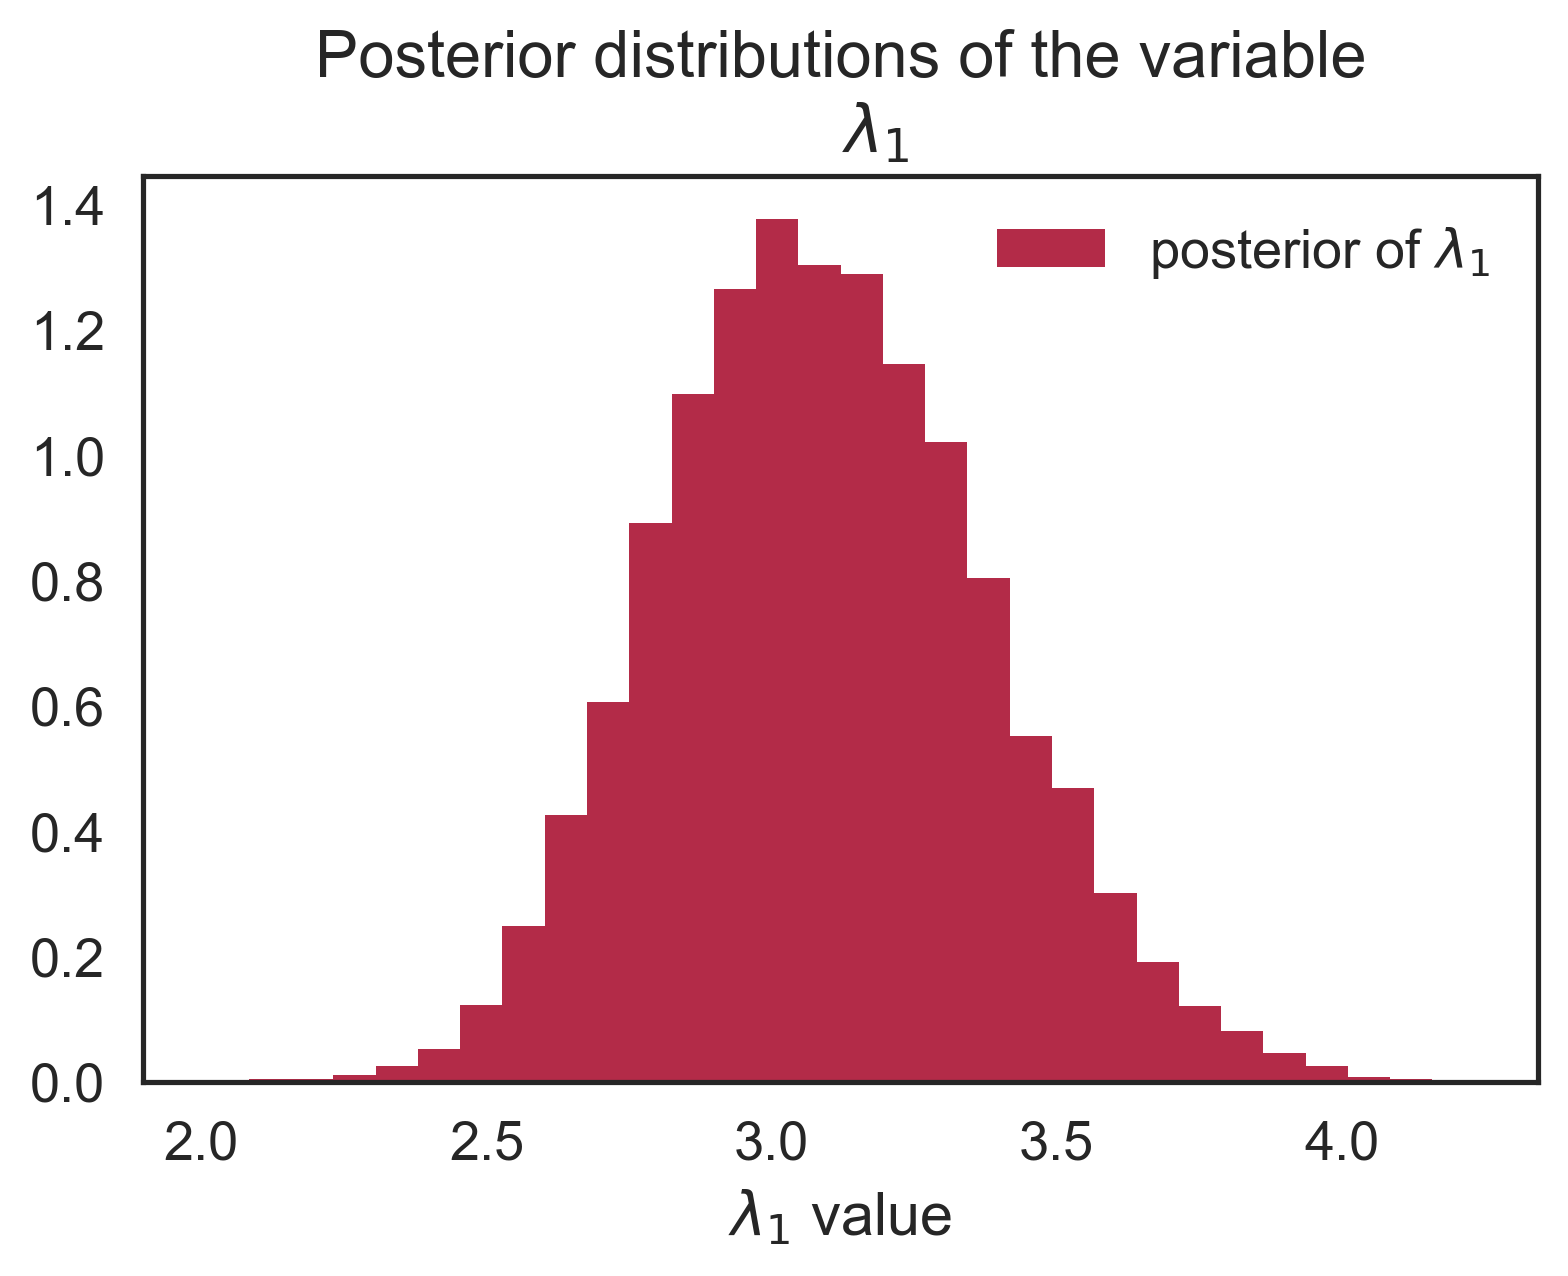

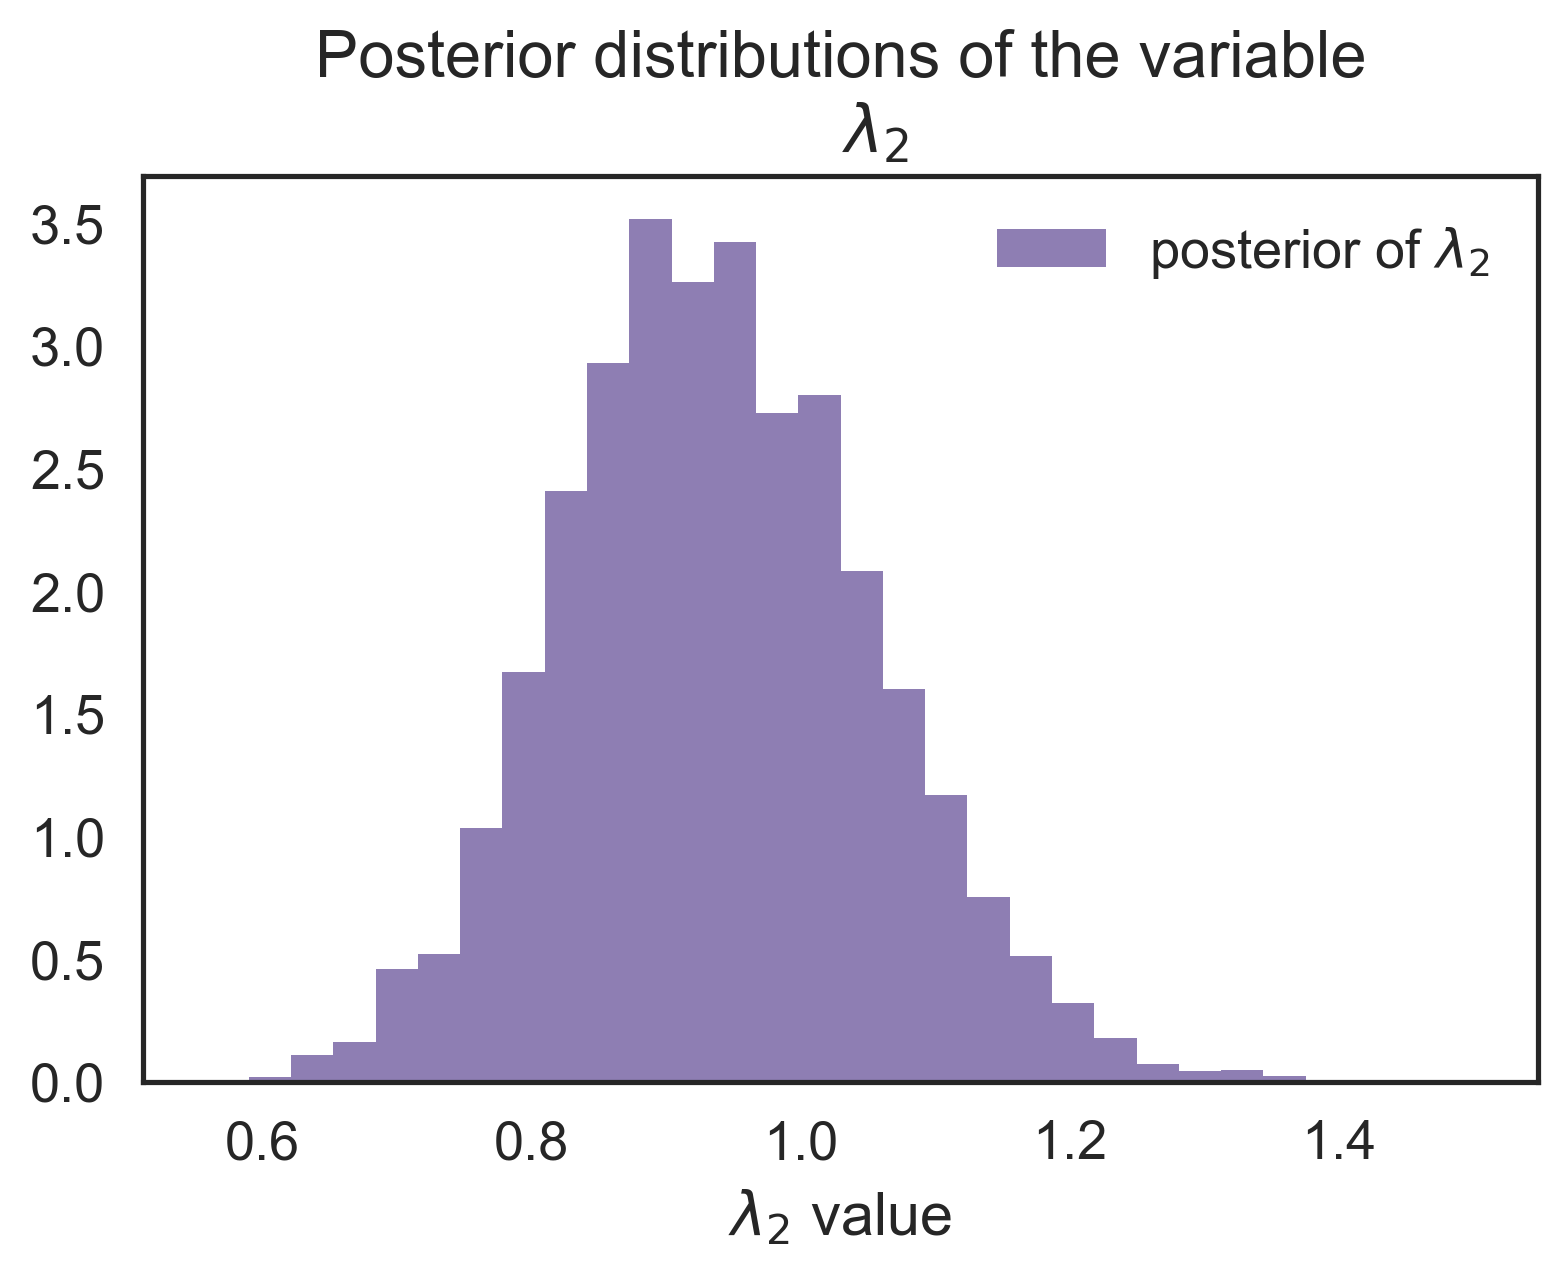

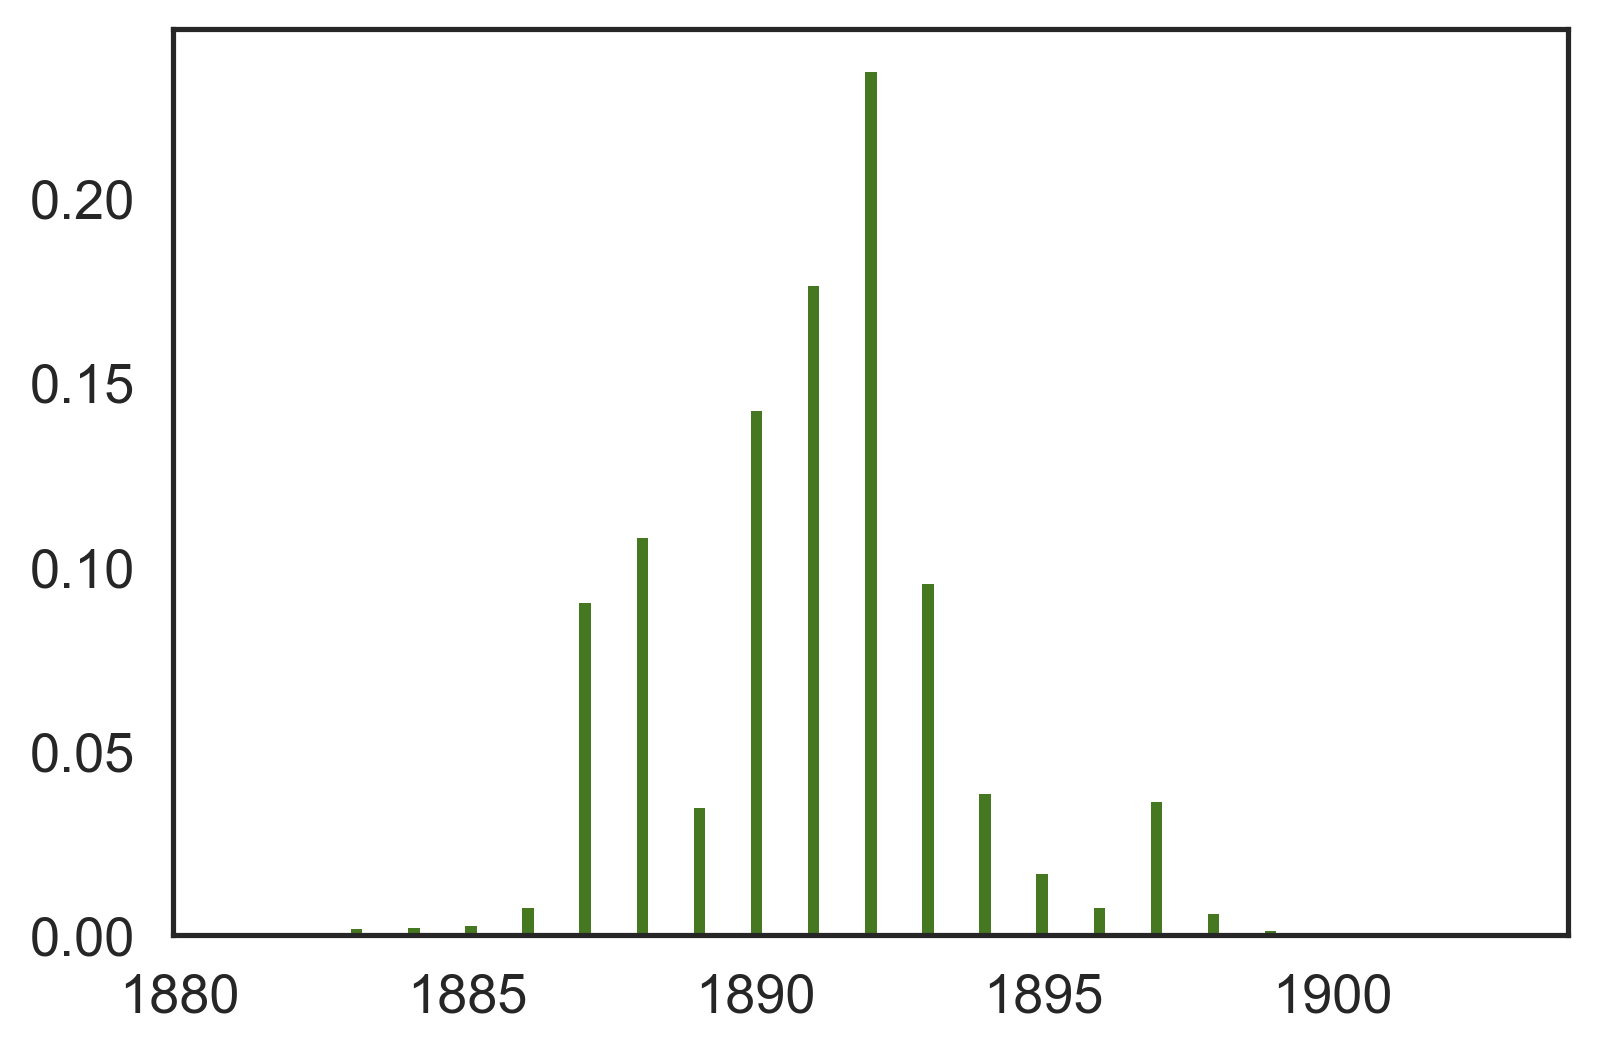

In [44]:
plt.figure()
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="best")
plt.title(r"""Posterior distributions of the variable
    $\lambda_1$""")
plt.xlabel("$\lambda_1$ value")

plt.figure()
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="best")
plt.title(r"""Posterior distributions of the variable
    $\lambda_2$""")
plt.xlabel("$\lambda_2$ value")

plt.figure()
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(1851 + tau_samples,bins=disaster_data.shape[0], alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.);

We'll use the posterior samples to answer the following question: what is the expected number of disasters in the year $t, \; 1851 \le t \le 1962$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ for year $t$*?

In the code below, let $i$ index samples from the posterior distributions. Given a year $t$, we average over all possible $\lambda_i$ for that year $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the policy interventions has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

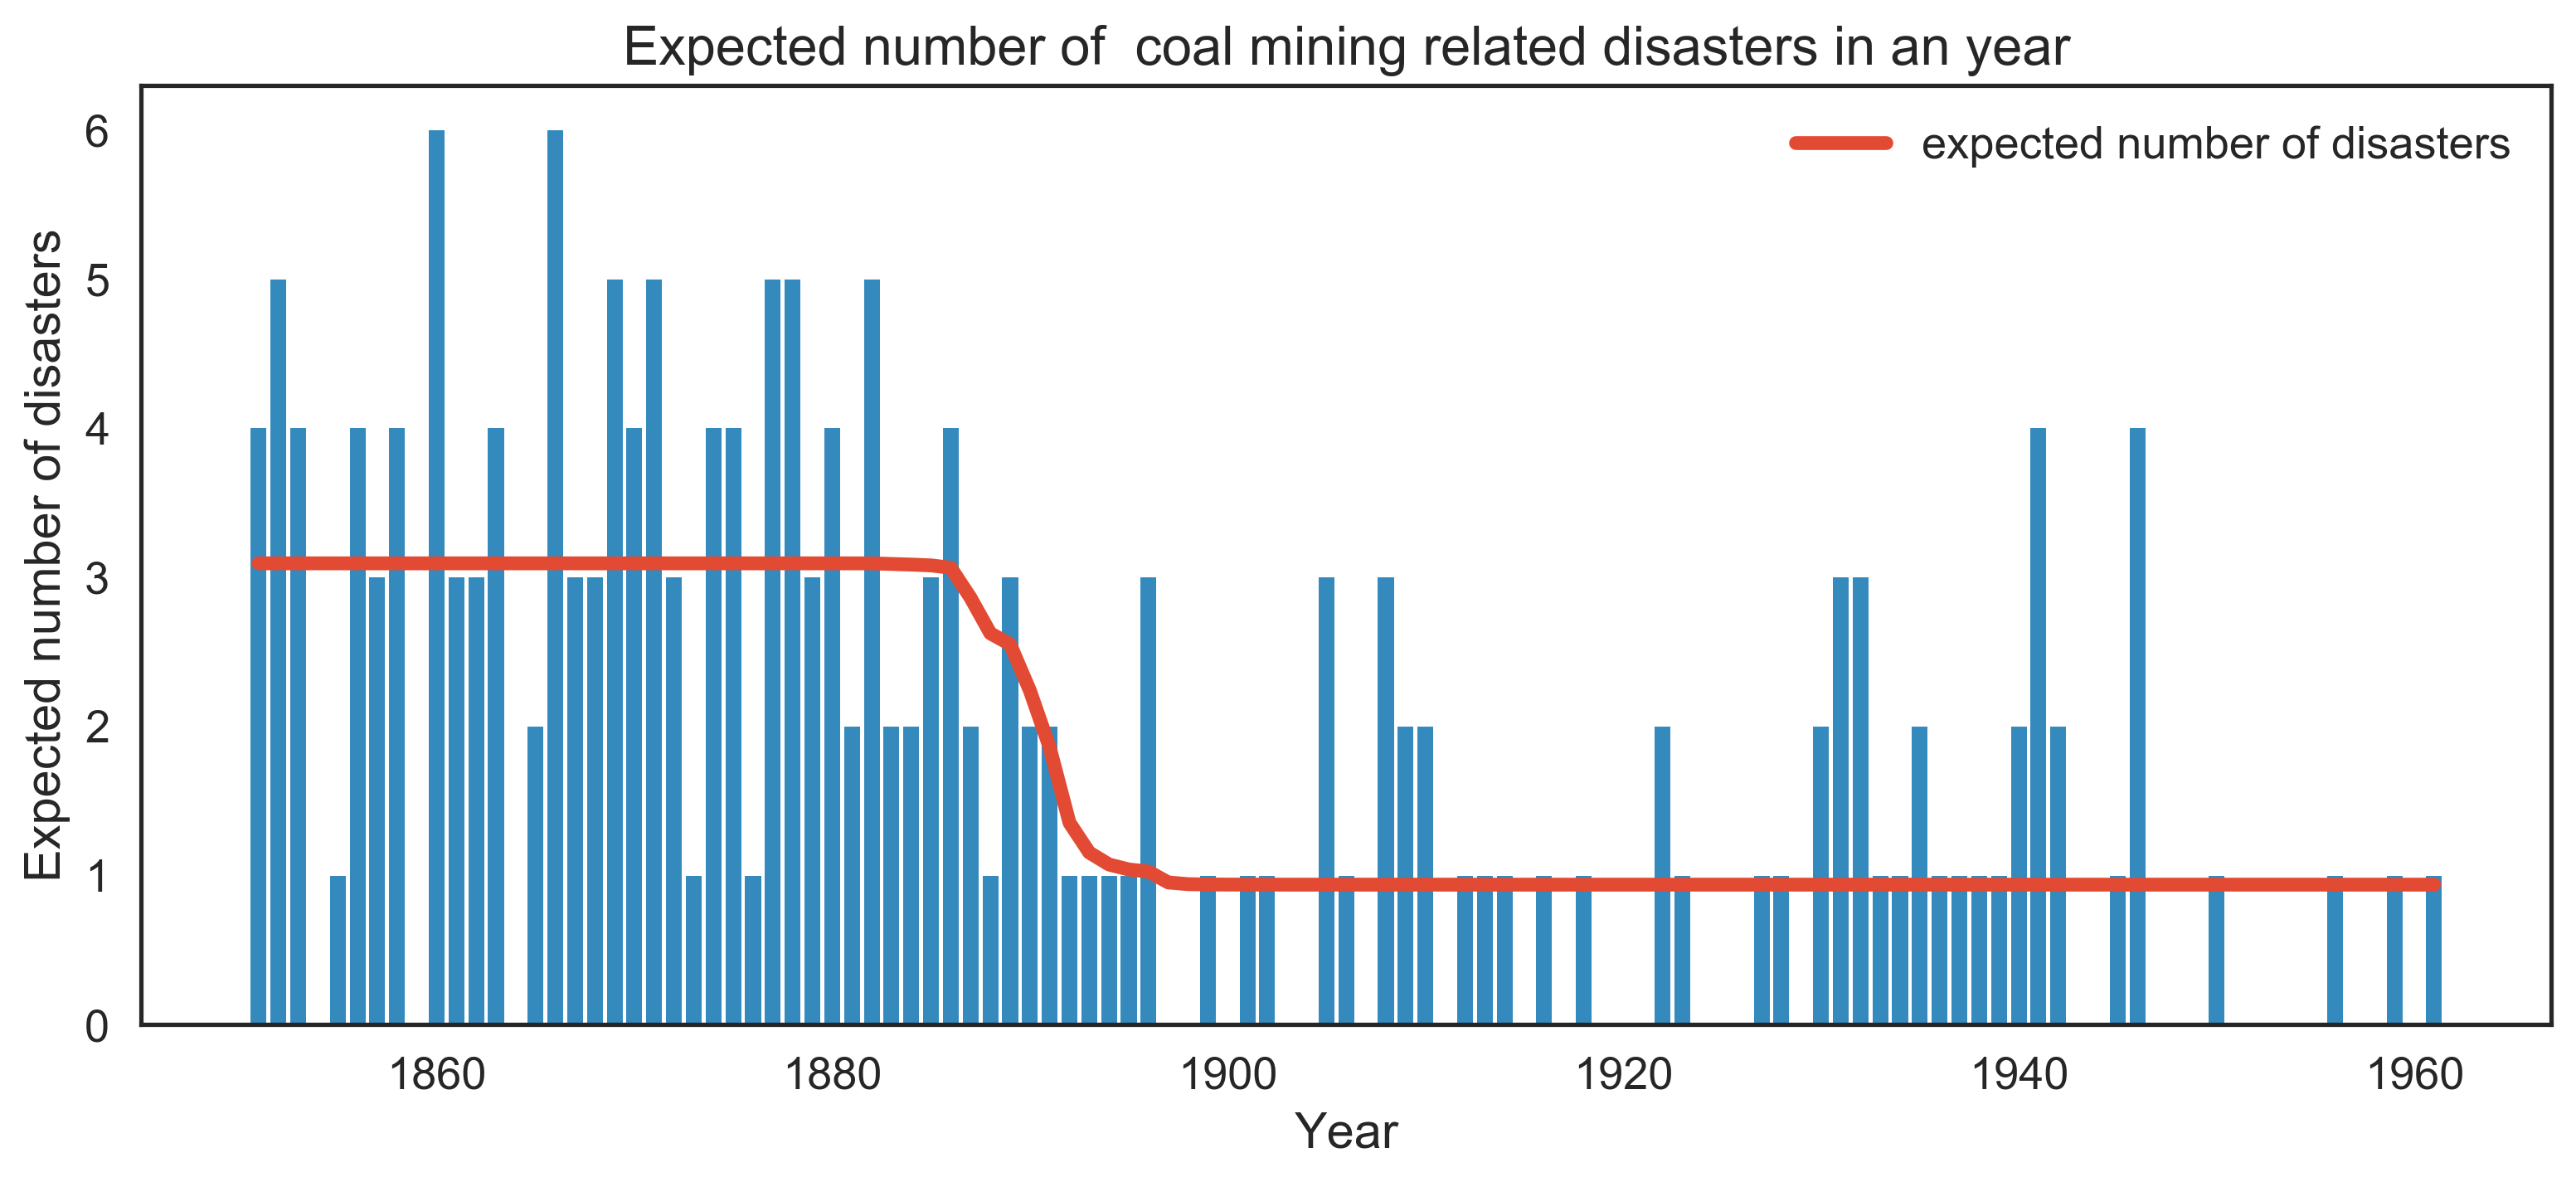

In [45]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
figsize(12.5, 5)
N = tau_samples.shape[0]
n_count_data = disaster_data.shape[0]
expected_disasters_per_year = np.zeros(n_count_data)
for year in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = year < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_disasters_per_year[year] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(1851 + np.arange(n_count_data), expected_disasters_per_year, lw=4, color="#E24A33",
         label="expected number of disasters")
#plt.xlim(0, n_count_data)
plt.xlabel("Year")
plt.ylabel("Expected number of disasters")
plt.title("Expected number of  coal mining related disasters in an year")
#plt.ylim(0, 60)
#plt.figure()
plt.bar(disaster_data.year, disaster_data.disasters, color="#348ABD")
plt.legend(loc="best");

# PyMC Tutorial 2 - Real Data Example : Challenger Space Shuttle Disaster

For this tutorial, we are going to work on Challenger space shuttle disaster dataset [1] . 

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [4]):

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


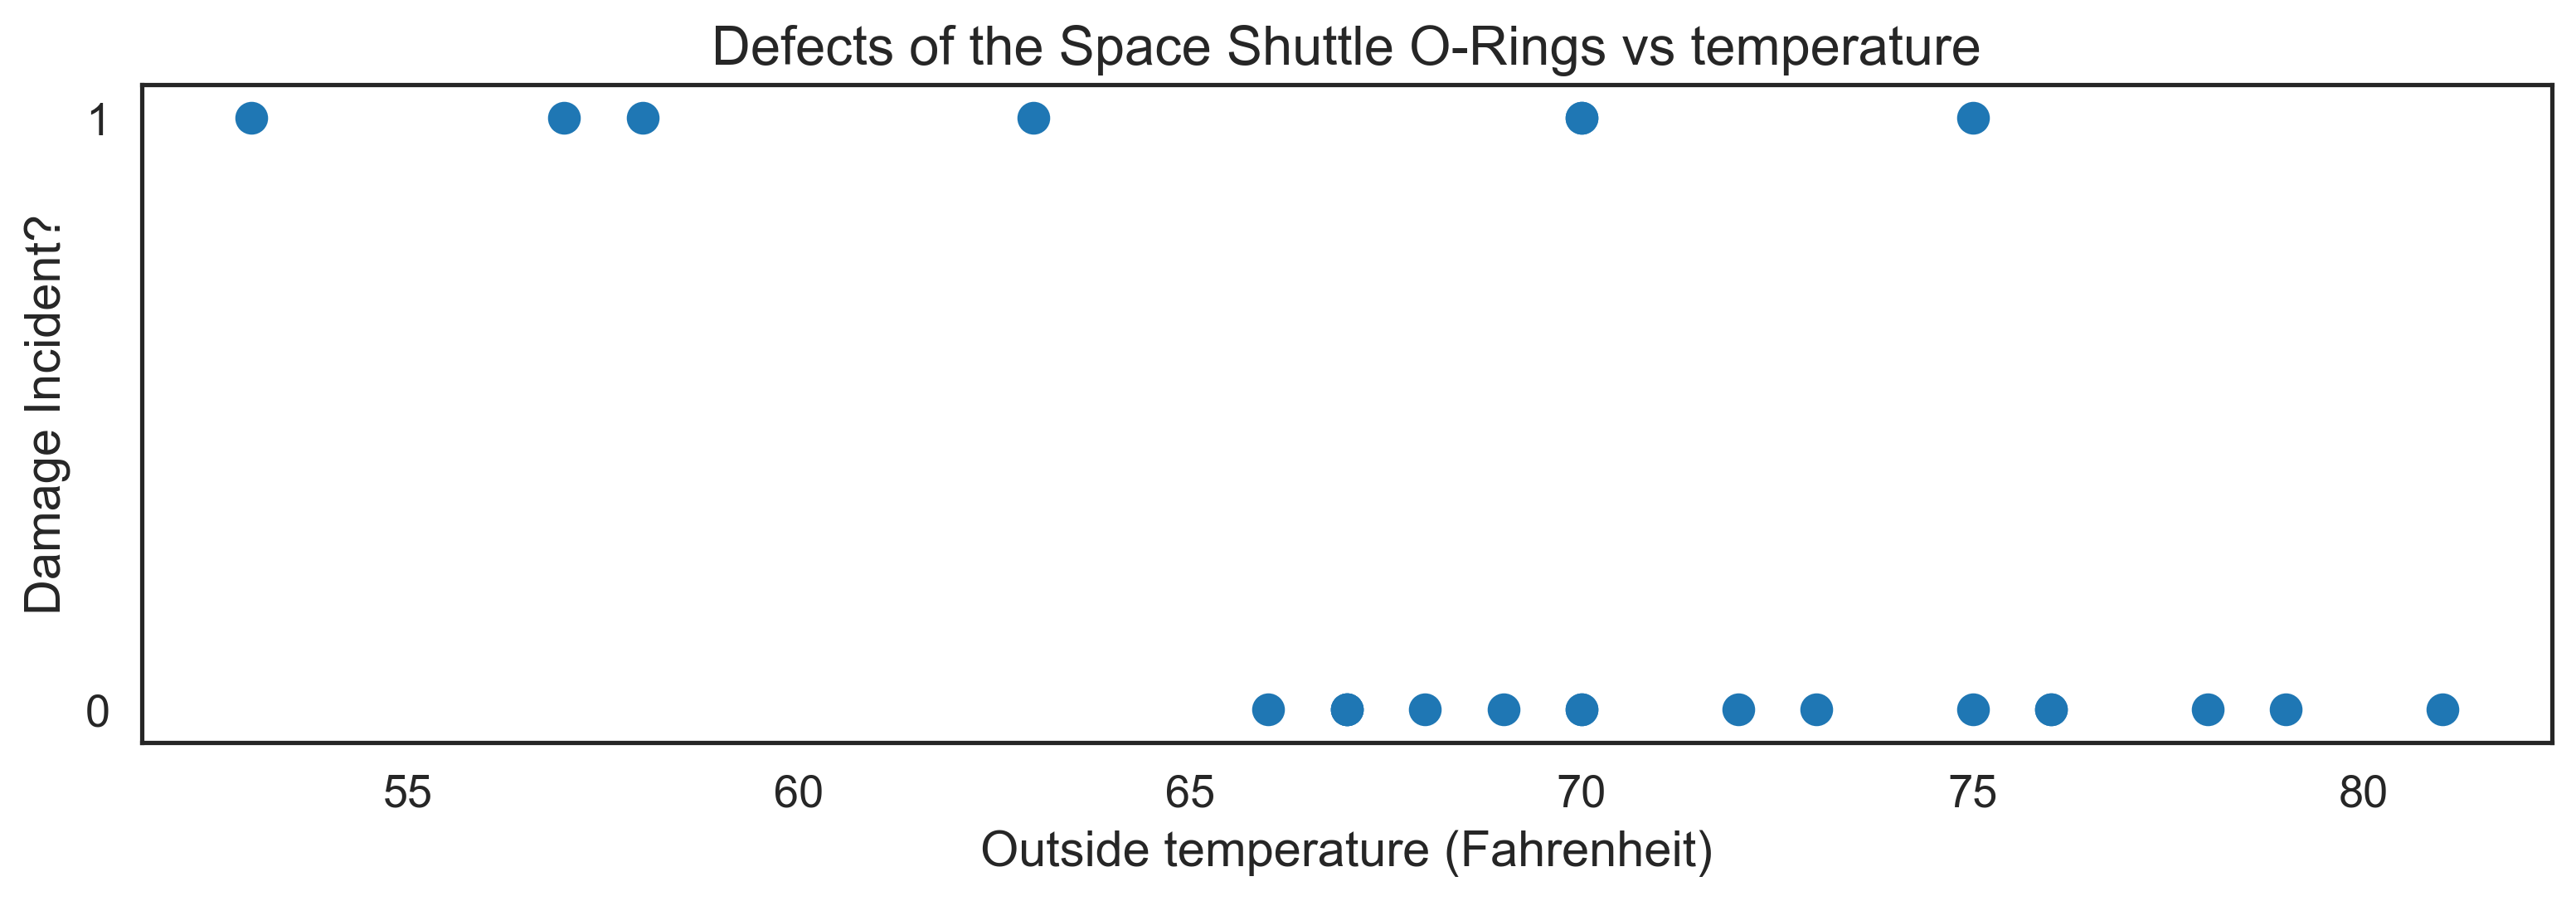

In [46]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1])
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

# Information about the dataset 
It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

## Questions

1. How can we represent this disaster binary 1/0 data? What are quantities of interests?
2. Is 'damage incident' variable categorial or continous? What are some other constraints?

# Modeling Approach

How are we going to develop model for this data? A good starting point would be to think about *how this data might be generated?* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated.

- We start by thinking "what is the best random variable to describe this binary categorical data?" A Bernoulli random variable is a good candidate because it can represent binary data. So we model the variable of 'damage incident' as sampled from a Bernoulli distribution. A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:
$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p_i\; ), \;\; i=1..N$$

- Next, we think, "Ok, assuming damage incident variable is Bernoulli-distributed, what do I need for the Bernoulli distribution?" Well, the Bernoulli distribution has a probability parameter $p_i$. 

-  Do we know $p_i$ parameter? No. But we have a suspicion (intuition) that this parameter is dependent on outside temperature values. Less the value of outside temperature, more is the probability of damage incident. More the value of outside temperature, less is the probability of damage incident. With slight abuse in notation, we can define this as:
$$p_i = p(t_i) = \sigma(t_i),$$

where $\sigma(\cdot)$ is the any link function (logistic, probit etc). For this problem, we are going to use logistic link function which is given as:
$$\sigma(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are shown below, with differing $\alpha$ and $\beta$ parameter values:



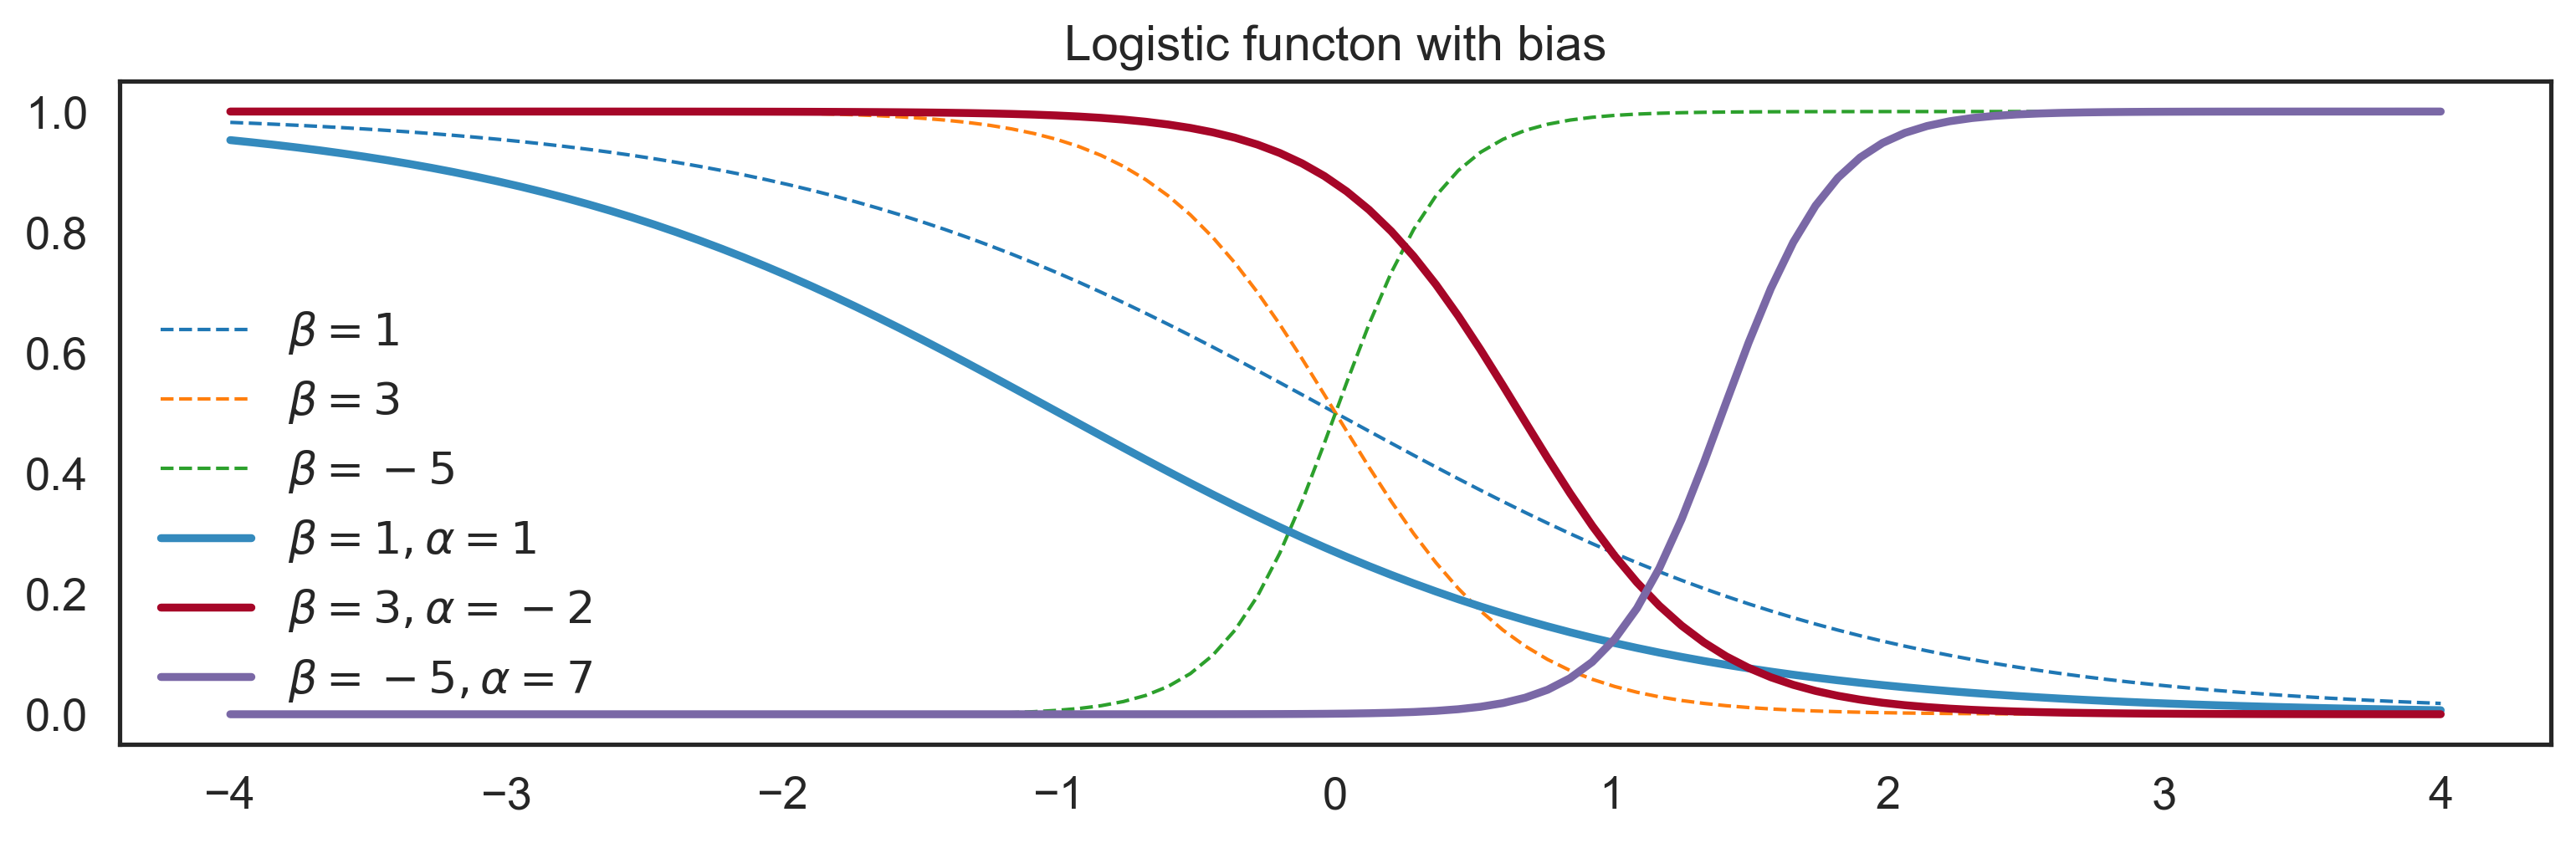

In [47]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.title("Logistic functon with bias", fontsize=14)
plt.legend(loc="lower left");

## Question

1. How can we represent  $\alpha$ and $\beta$ parameter values? Are they categorical or continous? Do they need to be positive?

- The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*. Since we dont have any prior beliefs about the value of parameters beta or alpha, we place a vague prior Normal distribution (small precision, large variance) over their values.



# Modeling with PyMC

The PyMC model code for solving this problem is taken from [Bayesian Methods for Hackers book](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) [3]).

## 1. Set up the model function

In [48]:
def make_model(challenger_data):
    """
    PyMC model (wrapping all the data and variables into a single function)
    Inputs:
    challenger data (23 x 2): Pandas dataframe ( Outside Temp vs. Damage Incident)
    Outputs:
    alpha, beta : stochastic parameters associated with the given model
    """
    # Load data
    temp = challenger_data[:, 0]
    temp_scaled = (temp - np.mean(temp))/np.std(temp) # to ensure proper mixing of MCMC chains
    D = challenger_data[:, 1]  # defect or not?
    
    # Define Prior
    beta = pm.Normal("beta", 0, 0.001, value = 0) # 0 mean and small 0.001 precision - vague prior
    alpha = pm.Normal("alpha", 0, 0.001, value = 0)
    
    @pm.deterministic
    def p(t=temp_scaled, alpha=alpha, beta=beta):
        return 1.0 / (1. + np.exp(beta * t + alpha))
    
    # Define likelihood
    # connect the probabilities in `p` with our observations through a
    # Bernoulli random variable.
    observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)
    
    return locals()

## 2. Sample from the posterior distribution

In [49]:
mcmc = pm.MCMC(make_model(challenger_data))
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 8.7 sec

## 3. MCMC Convergence Diagnostics and Posterior Distributions

Plotting beta
Plotting alpha


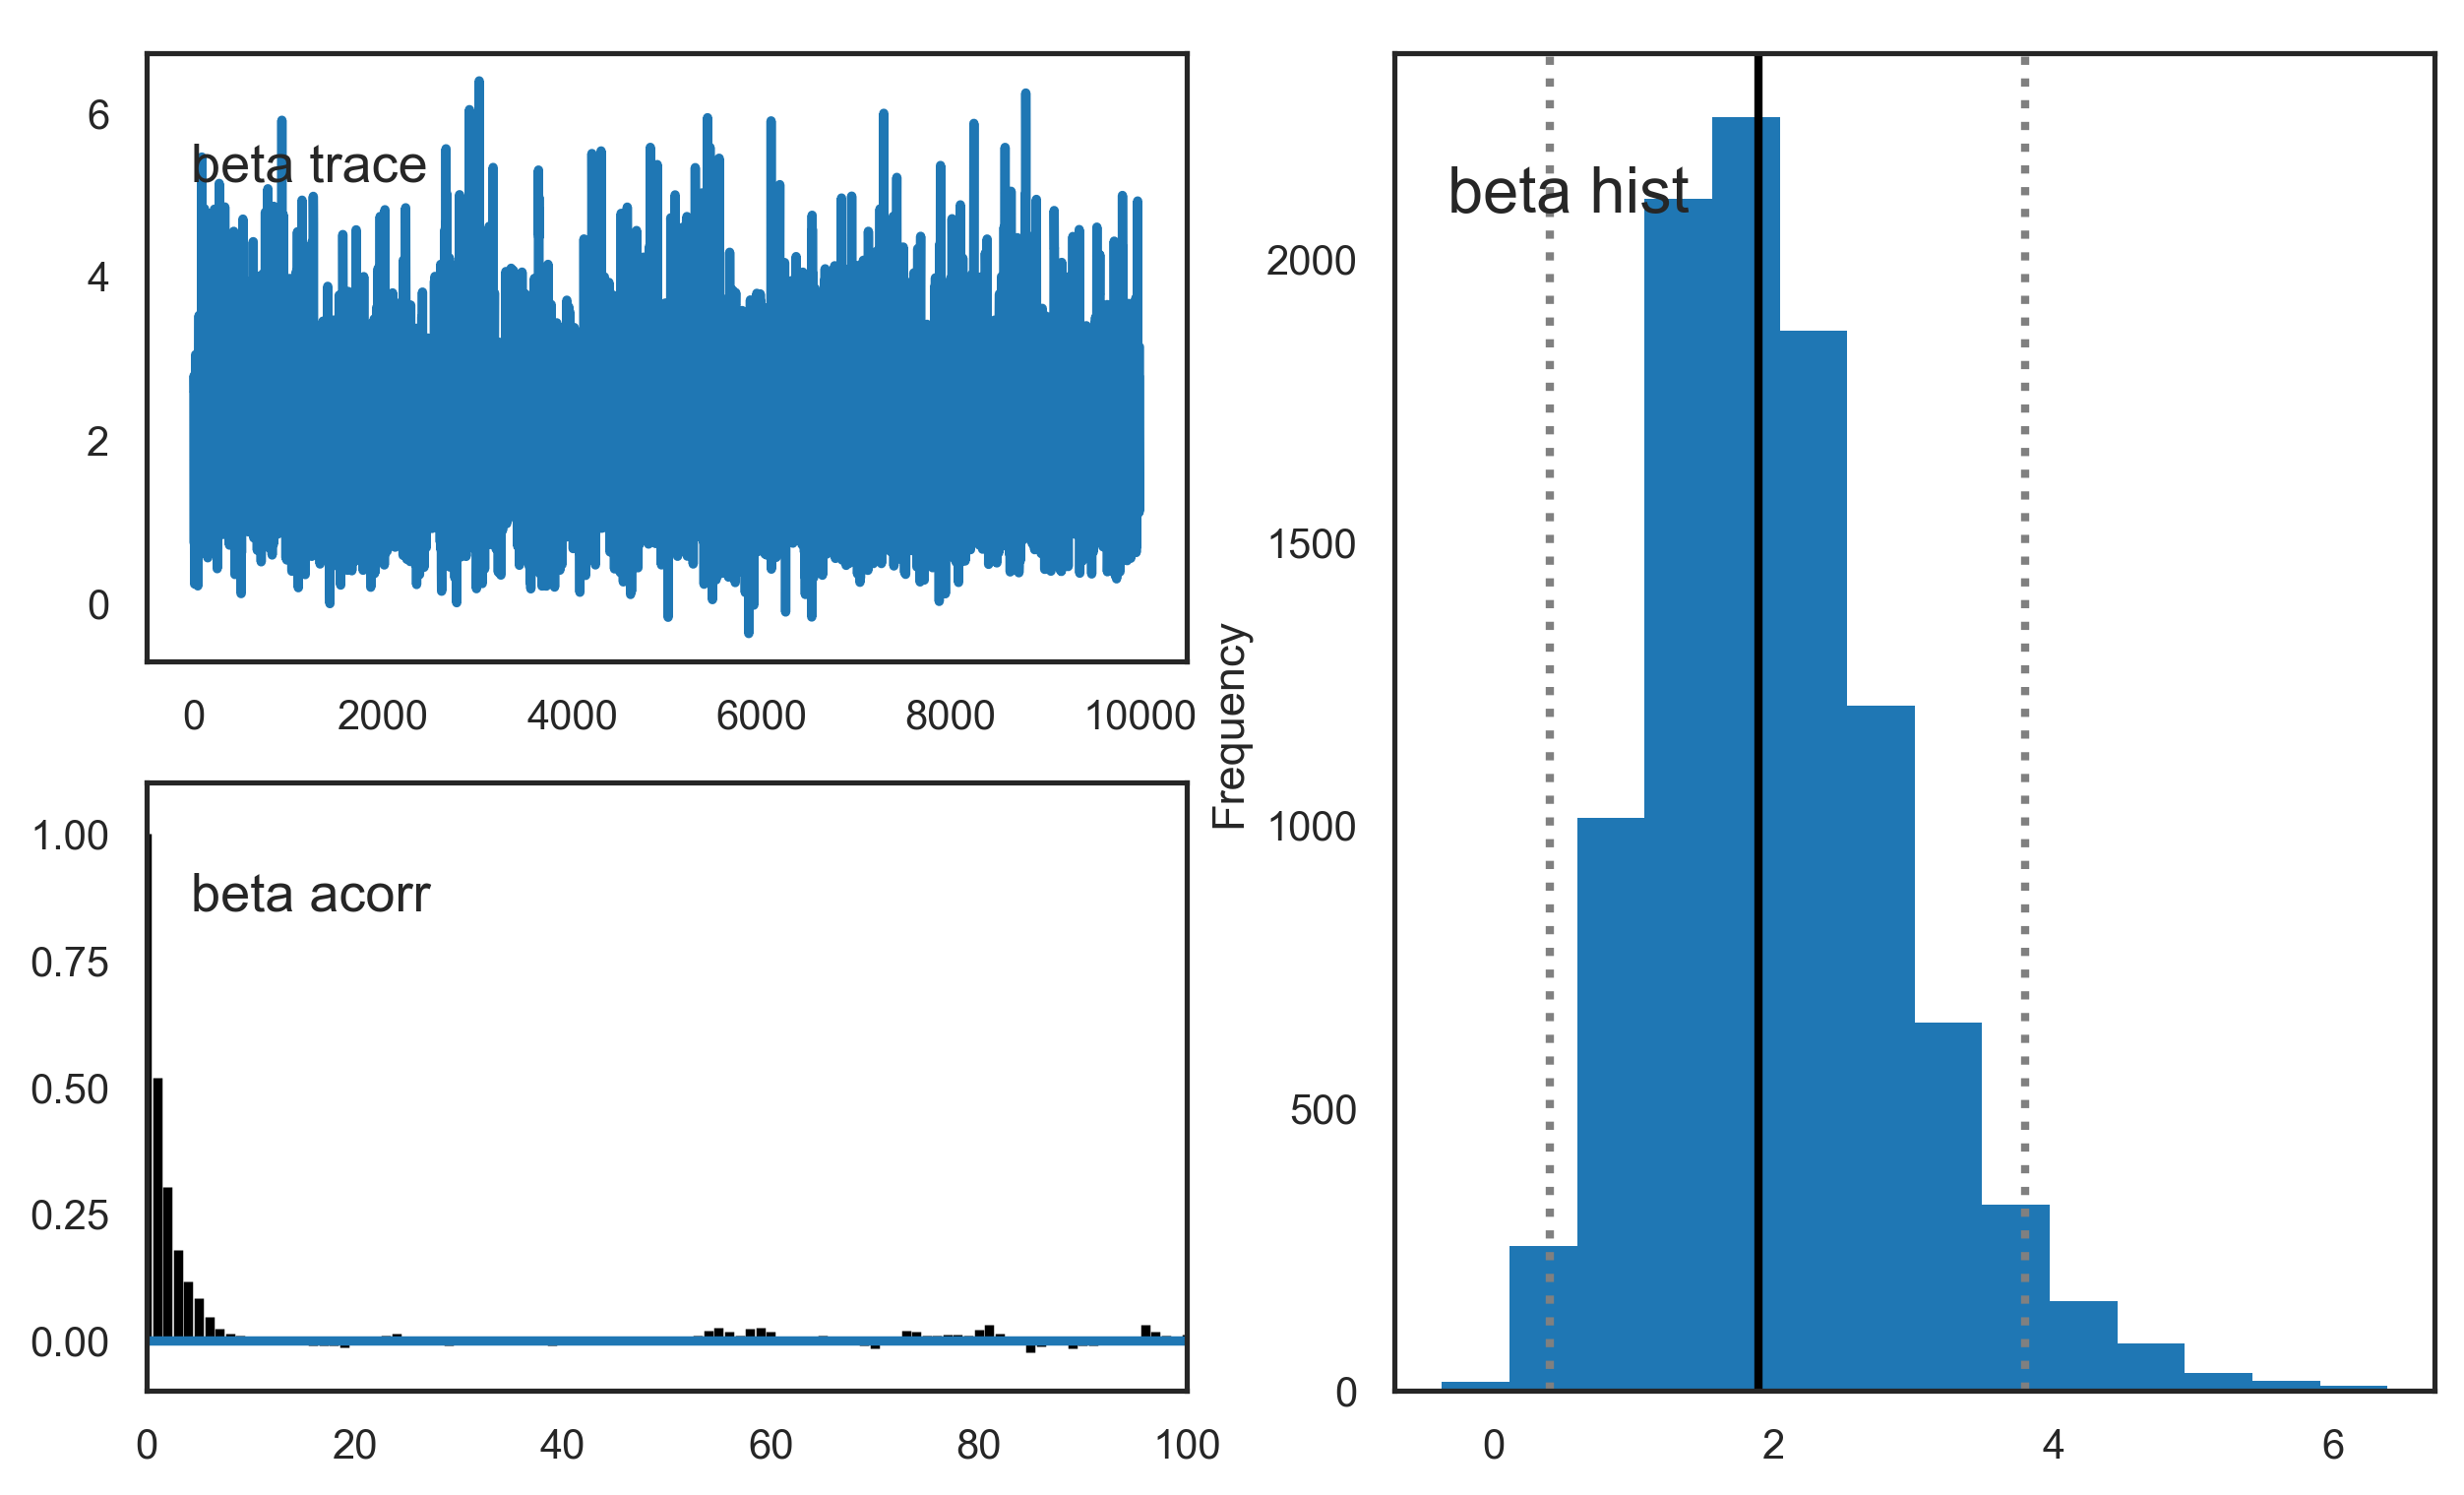

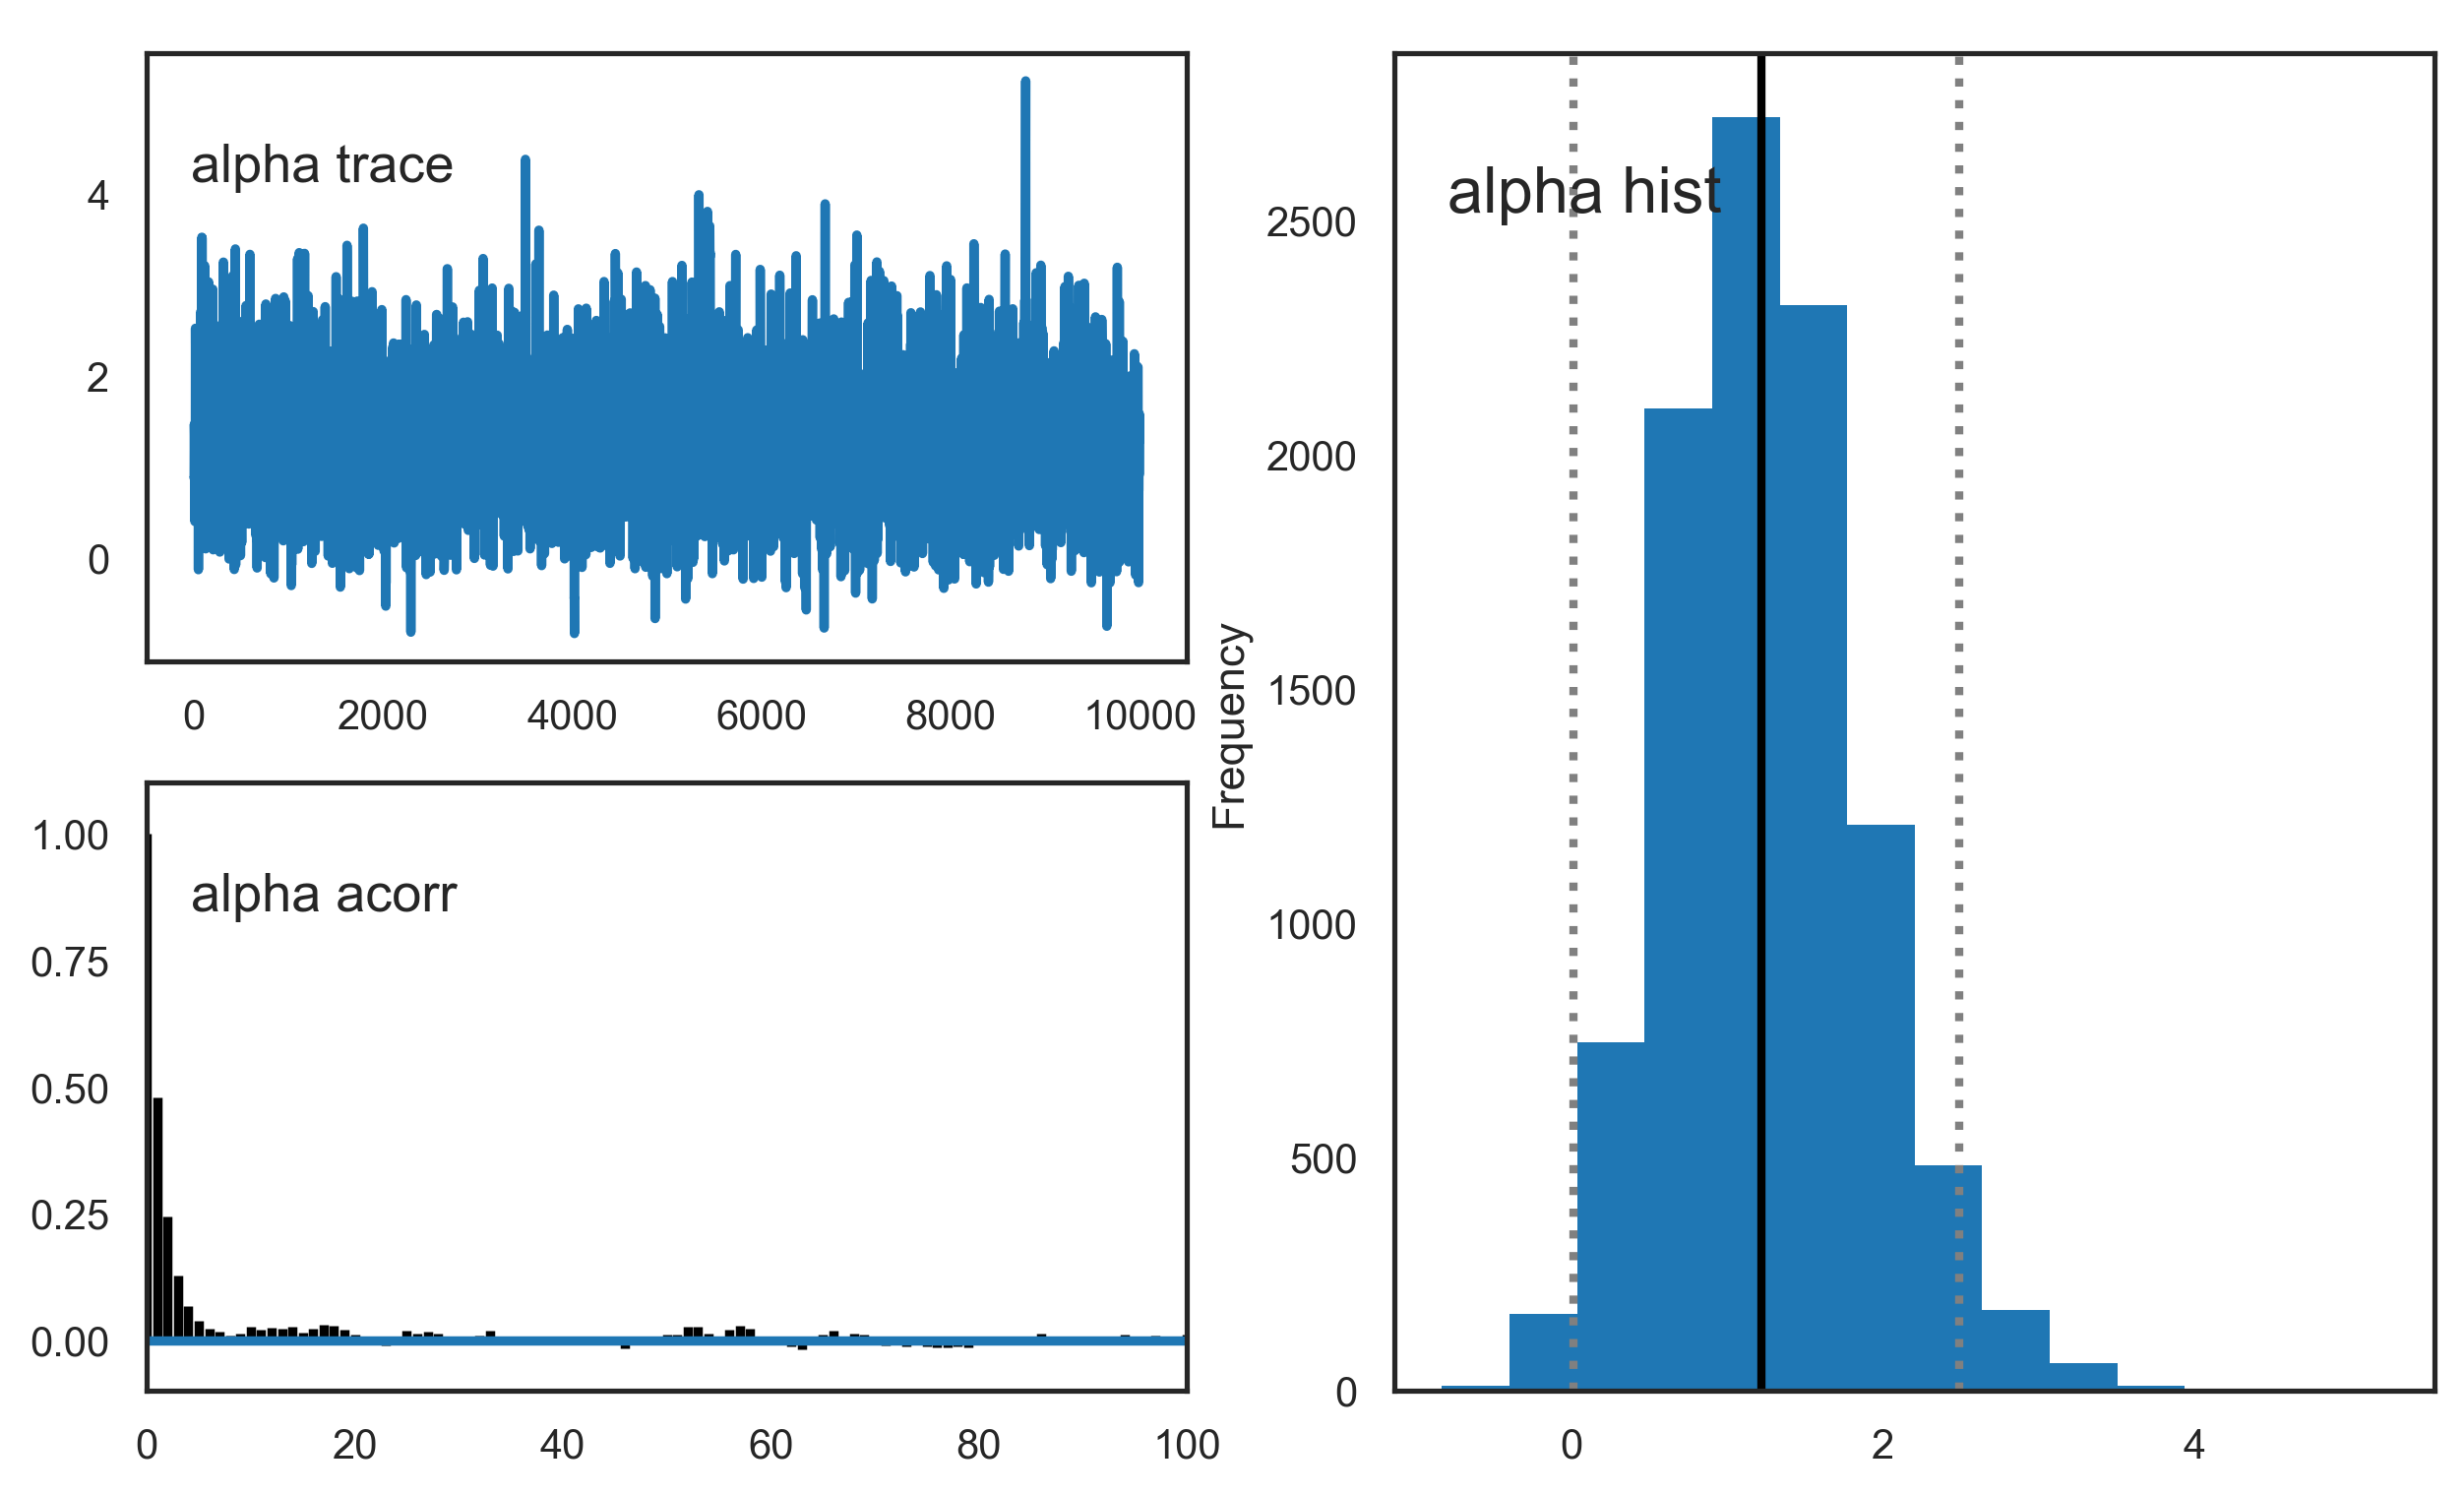

In [50]:
from pymc.Matplot import plot
plot(mcmc)

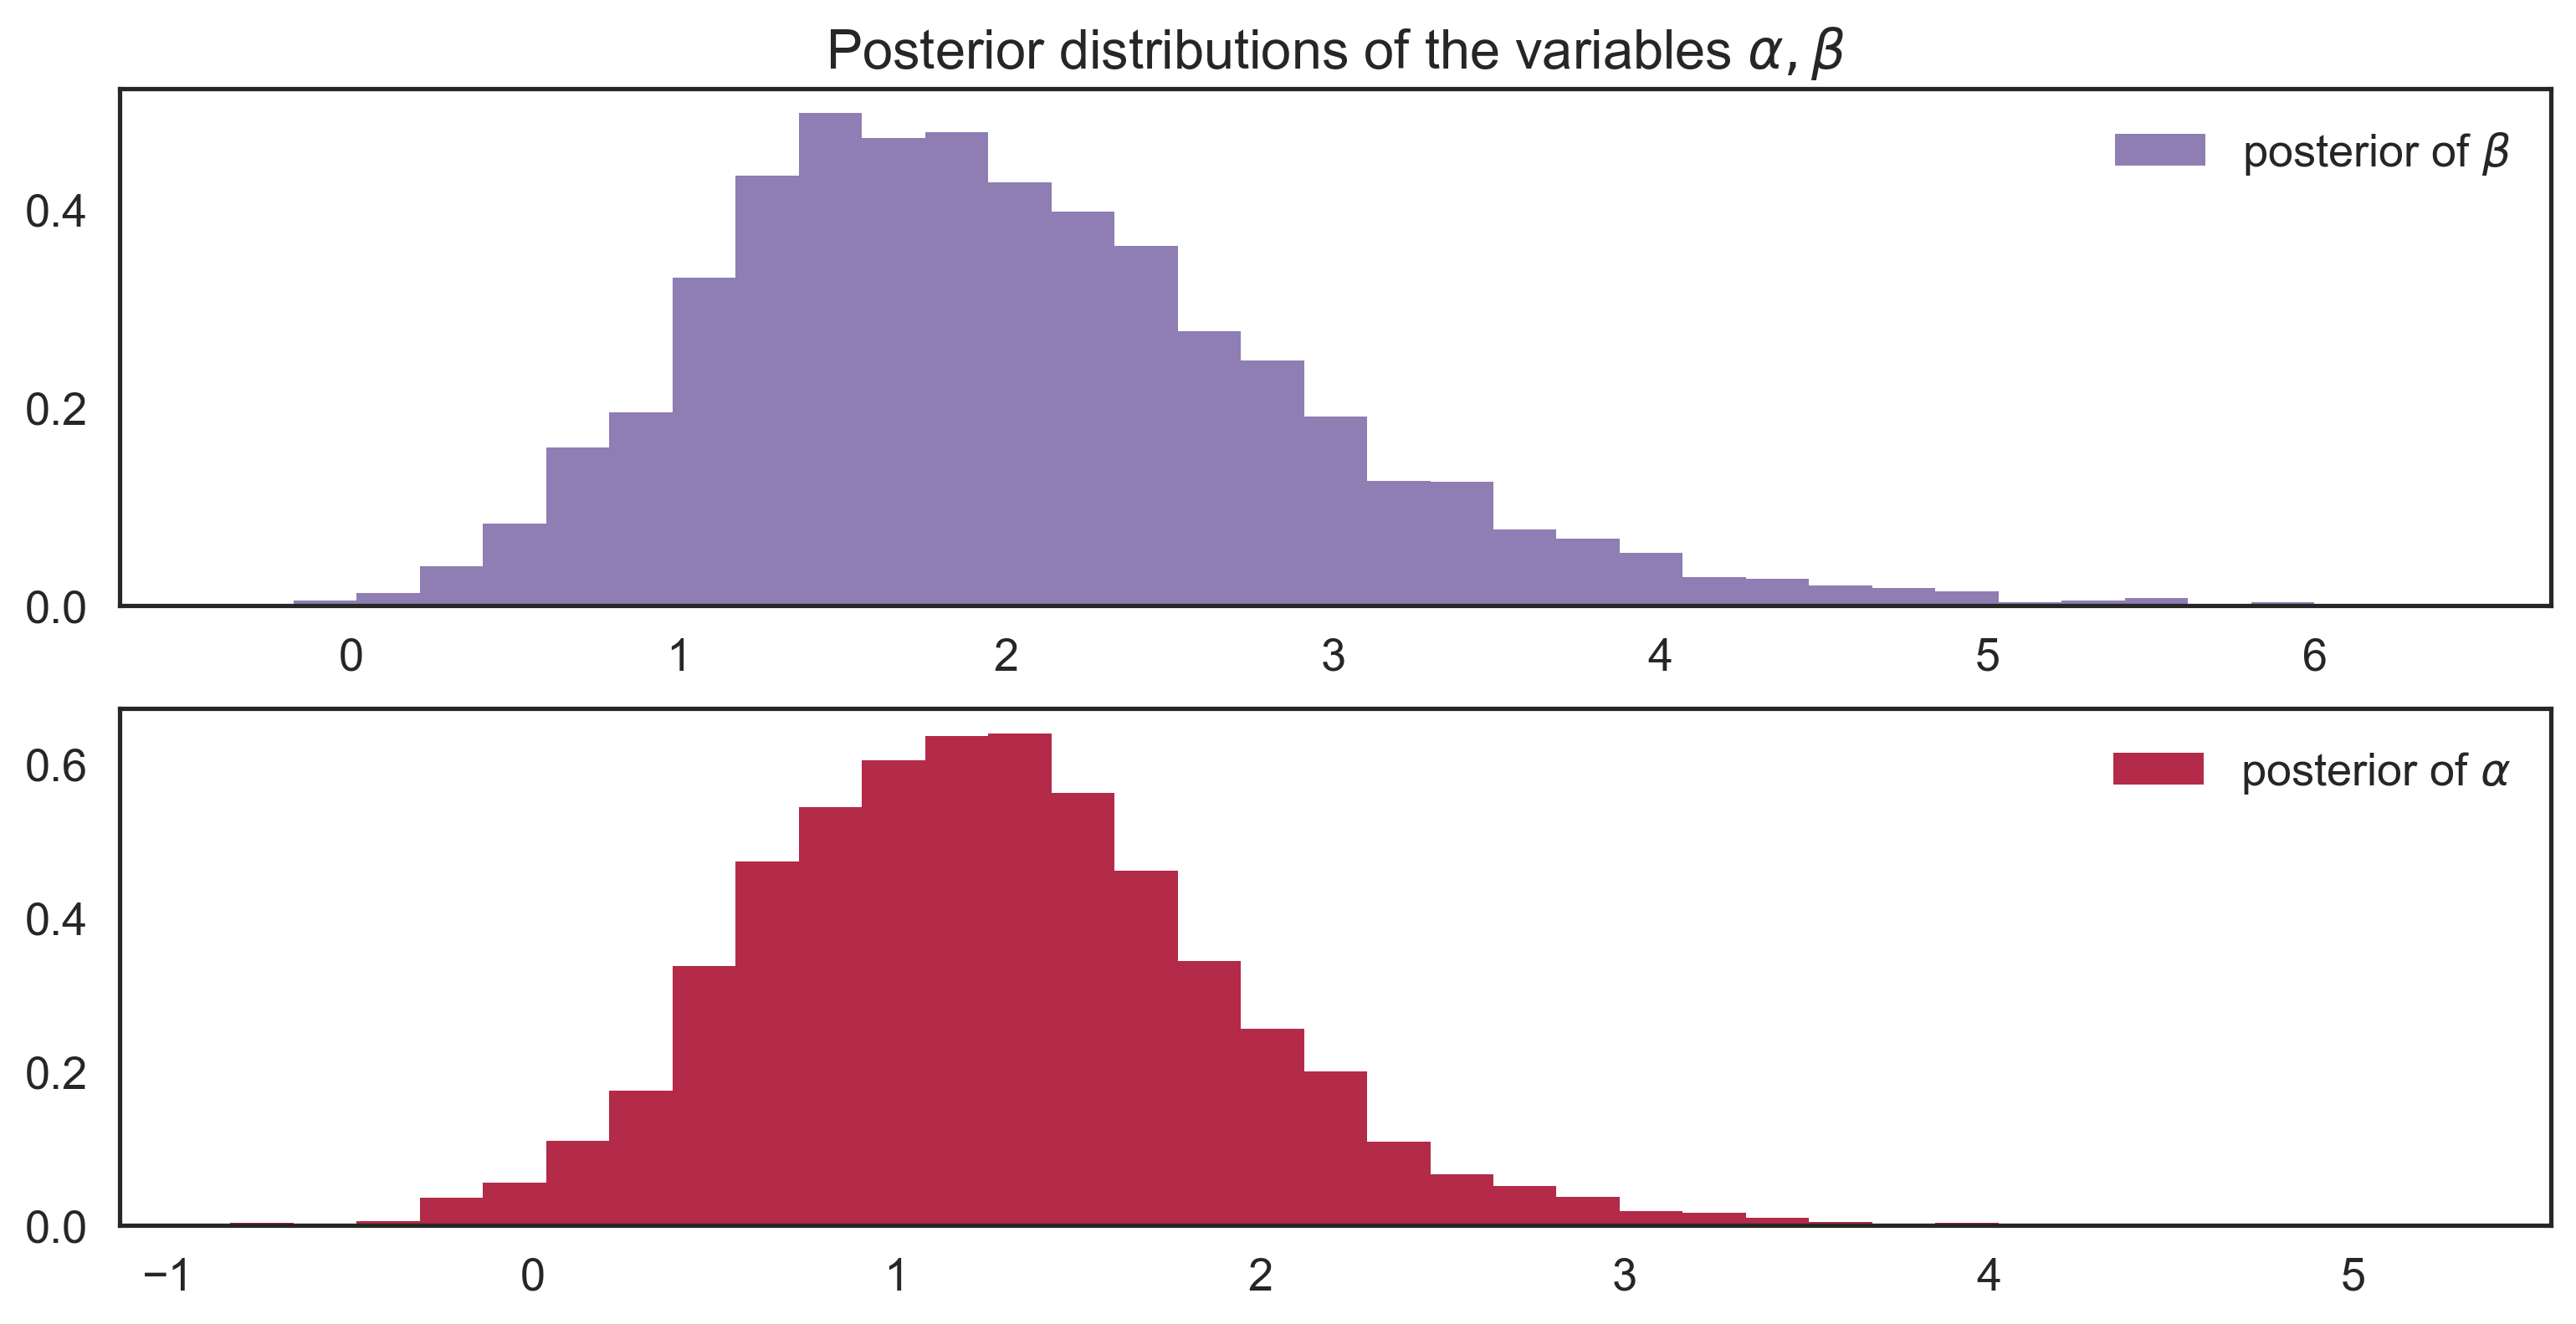

In [51]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

All samples of $\beta$ are greater than 0. If instead the posterior was centered around 0, we may suspect that $\beta = 0$, implying that temperature has no effect on the probability of defect. 

## 4. Posterior Predictive Distribution

In [52]:
temp = challenger_data[:, 0]
D = challenger_data[:, 1]

t = np.linspace(temp.min() - 5, temp.max() + 5, 50)[:, None]
t_scaled = (t - np.mean(temp))/np.std(temp)
p_t = logistic(t_scaled.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

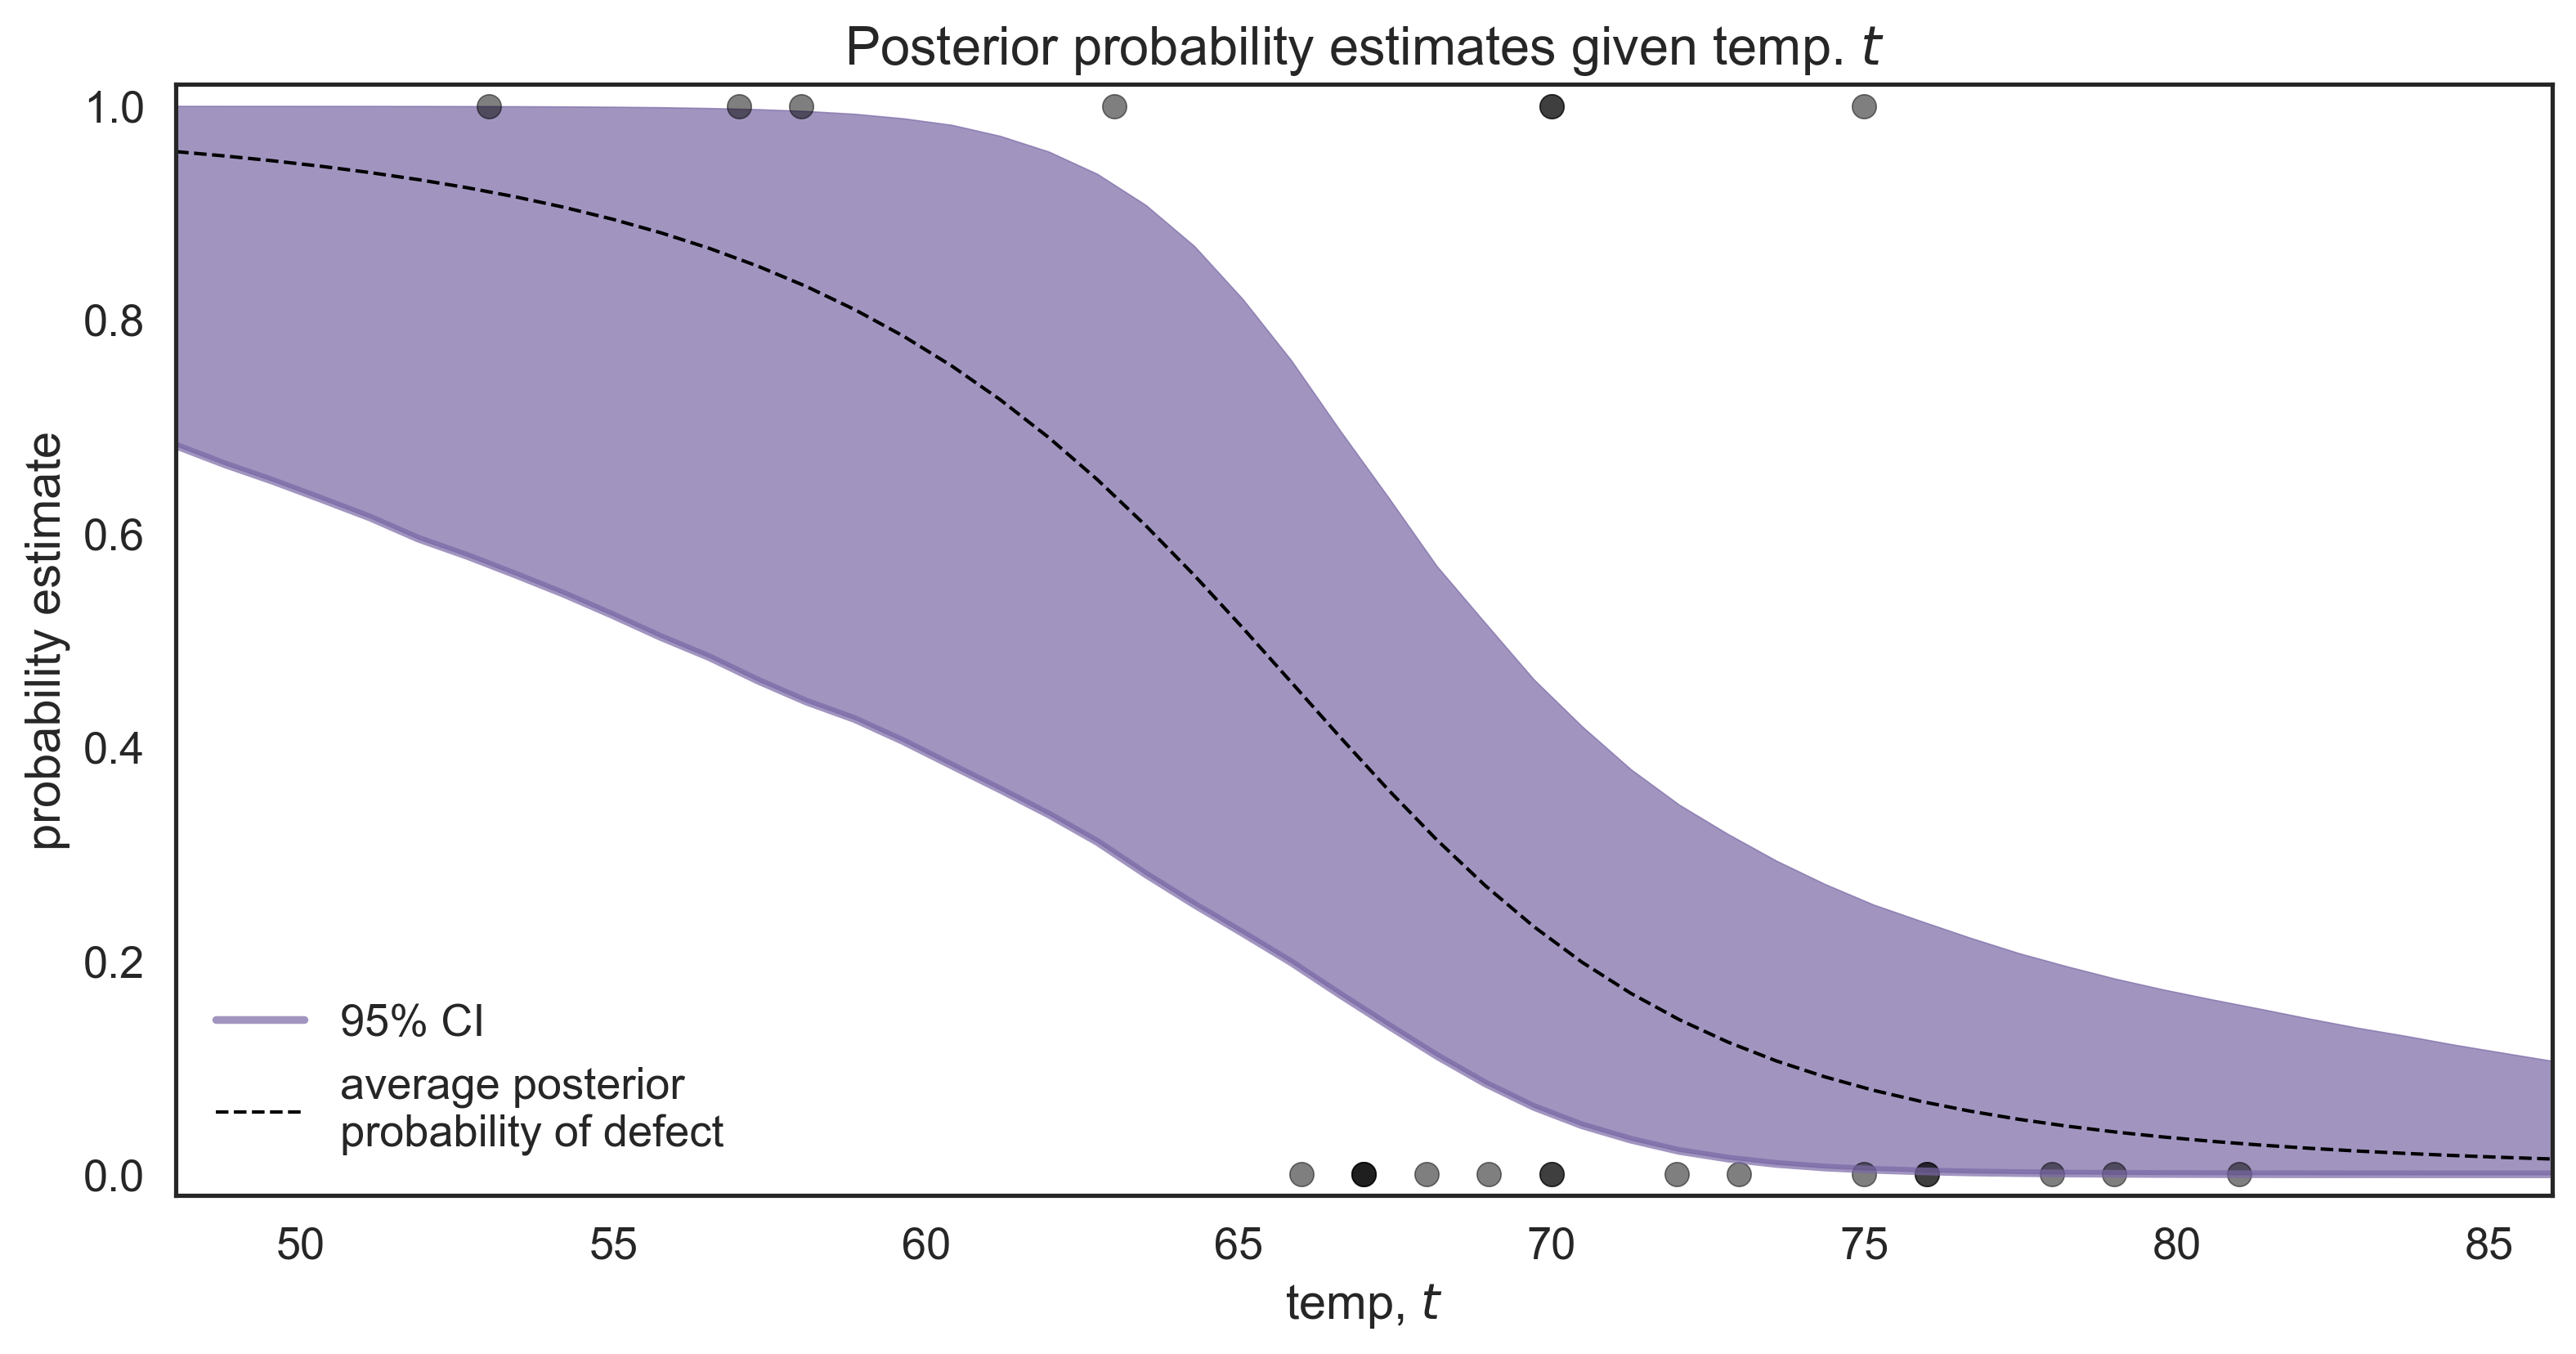

In [53]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temp, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over [0,1] quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

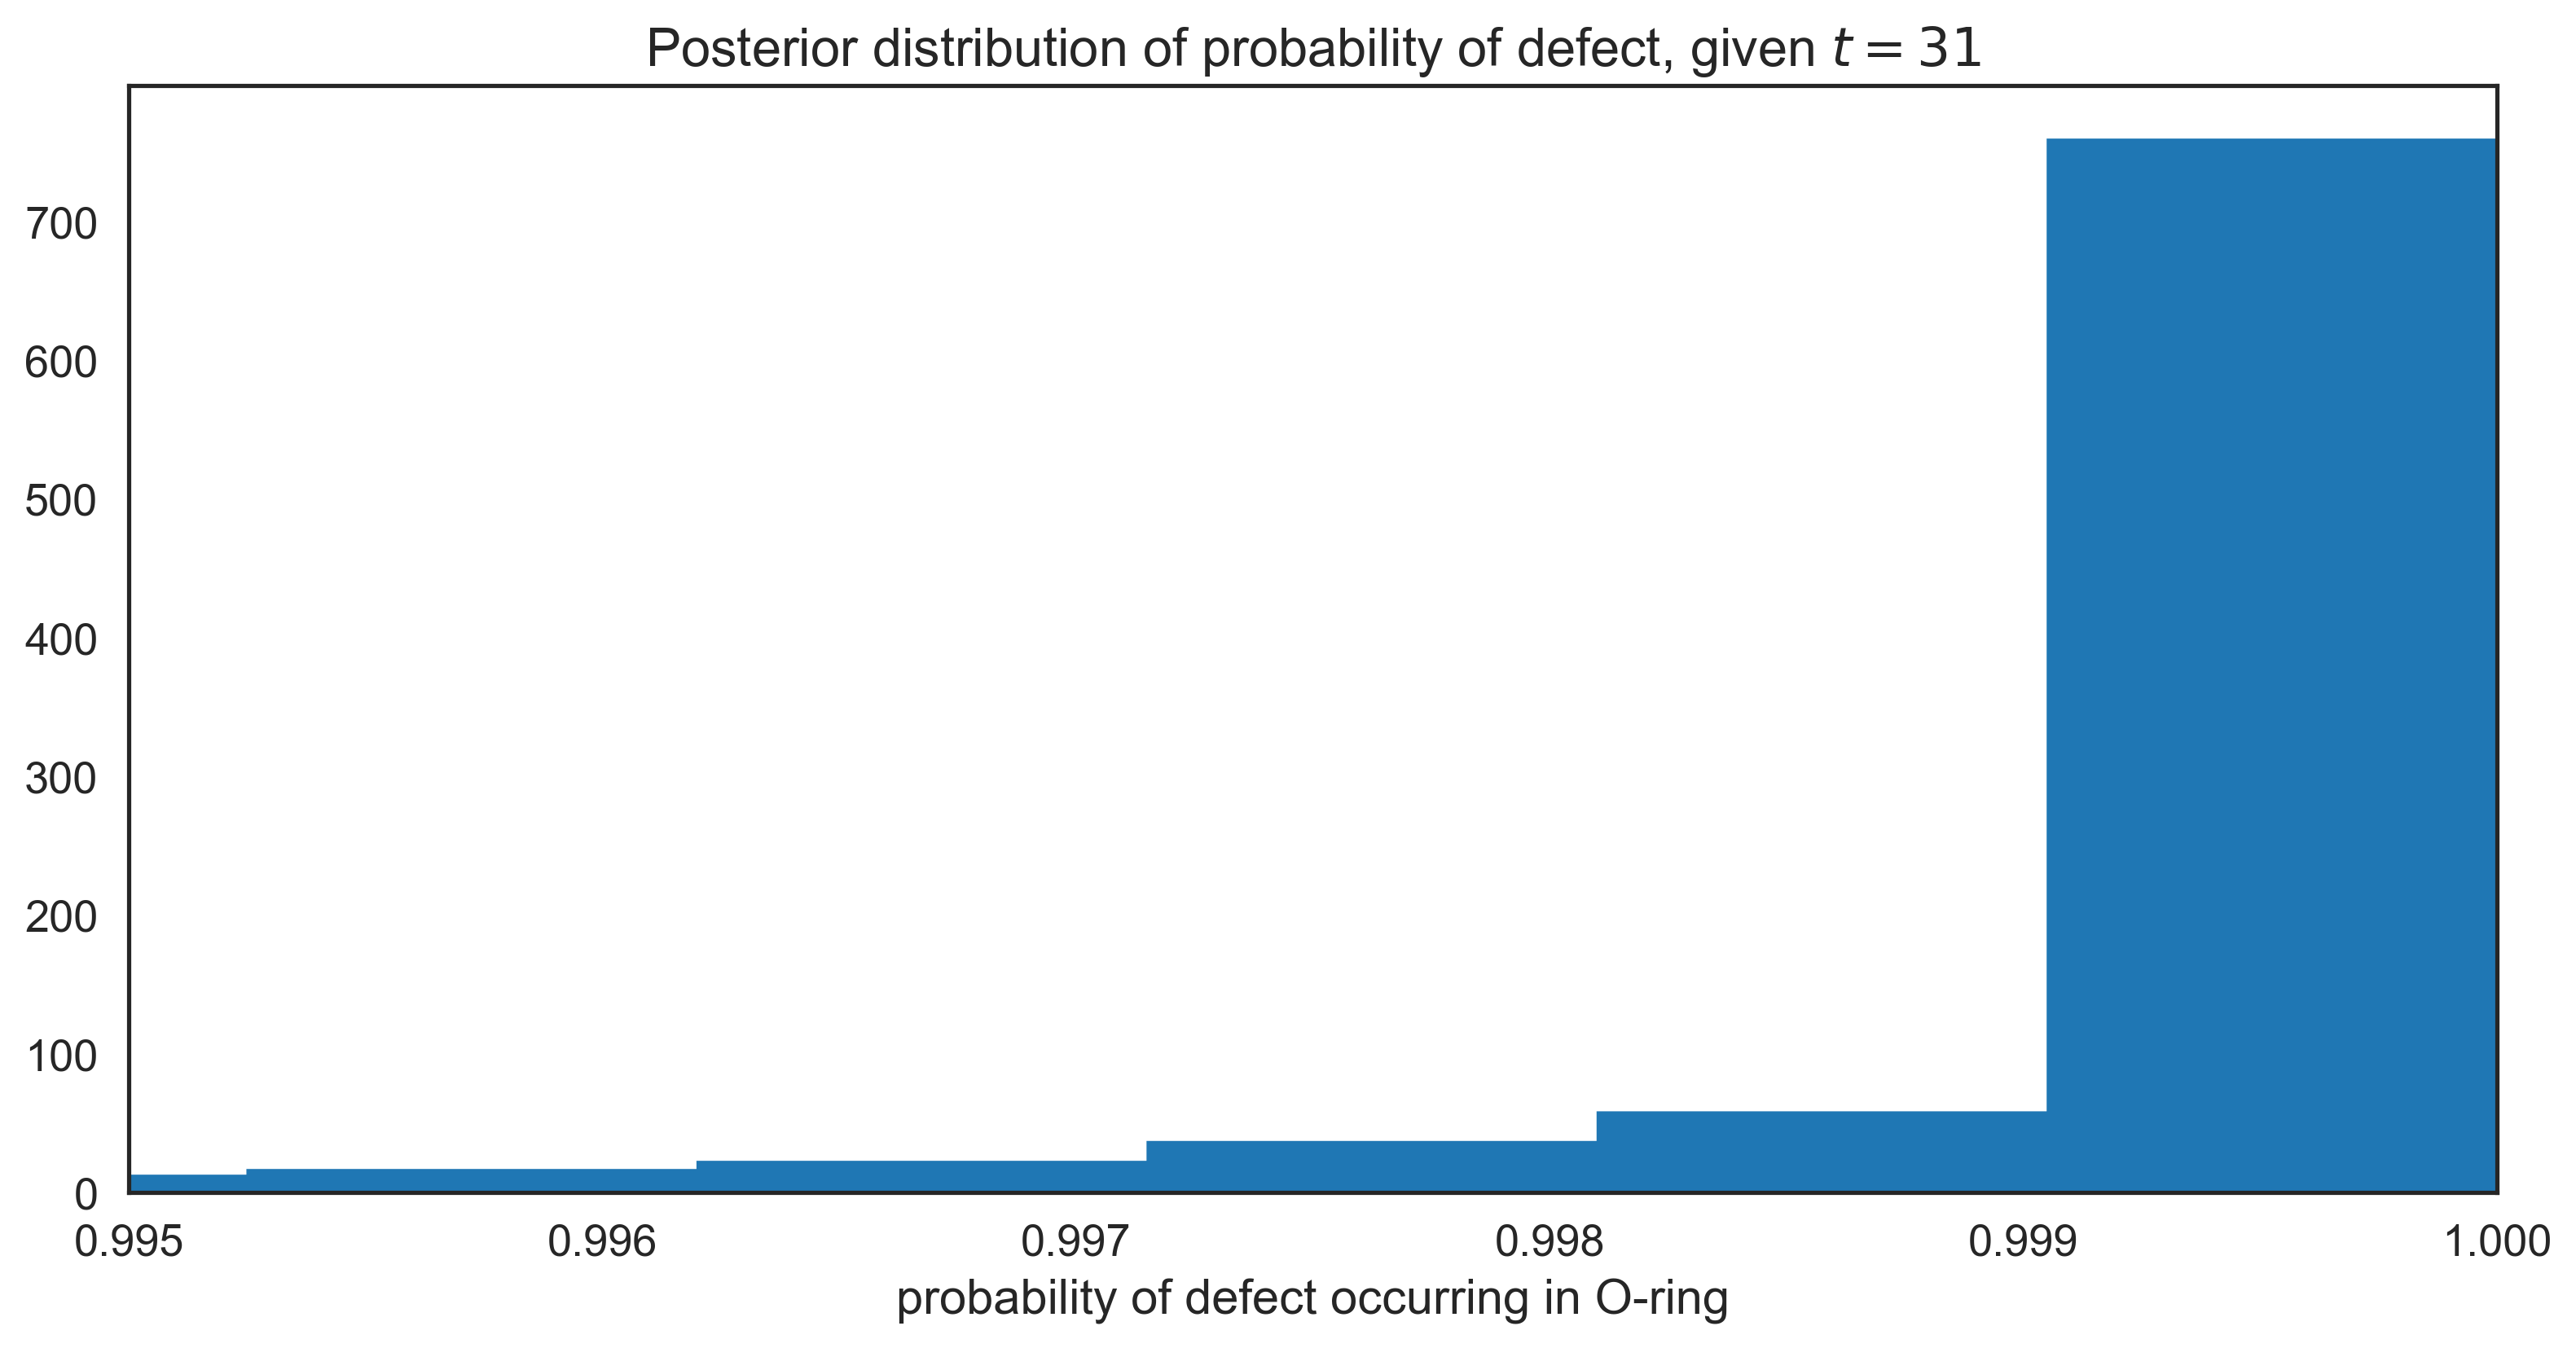

In [54]:
actual_disaster_temp_scaled = (31 - np.mean(temp))/np.std(temp)
prob_31 = logistic(actual_disaster_temp_scaled, beta_samples, alpha_samples)
plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

## References
- [1] R.G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.
- [2] http://pymc-devs.github.io/pymc/tutorial.html
- [3] https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
- [4] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.